In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(1, '../scripts/')
from utils import *
from processing import *
import pickle
from hyperopt import tpe, fmin, hp
from hyperopt.pyll.base import scope
from sklearn.decomposition import PCA
import shap
import torch
from torch import nn 
import torch.nn.functional as F
from skorch import NeuralNetClassifier

This notebook runs classification algorithms based on the first 24 hours of a patient's stay. Unlike static_cv.ipynb, this notebook only examines patients with CAM ICU tests, which we interpret to be more reliable than the diagnosis table. This notebook will use mean/common imputation, for RF imputation, see other notebook.

# Load Data

In [4]:
data = load_data("prediction_cam")
data

PatientStayID  Class   Age  APACHEIVscore  APACHEIVaScore  Metabolic  \
0             242154      1  46.0           77.0            77.0          0   
1             242290      0  75.0           77.0            77.0          0   
2             242474      0  52.0           64.0            64.0          1   
3             242505      1  90.0           78.0            78.0          0   
4             242714      0  78.0           -1.0            -1.0          0   
...              ...    ...   ...            ...             ...        ...   
18300        3352193      0  19.0           -1.0            -1.0          1   
18301        3352331      0  75.0           48.0            48.0          0   
18302        3352964      0  85.0           75.0            75.0          0   
18303        3353044      0  52.0           41.0            41.0          0   
18304        3353077      0  60.0           36.0            36.0          0   

       UrgentAdmission  AdmissionCategory  Infection  NumBeds  ...  \
0                  1.0                2.0       True      4.0  ...   
1                  1.0                2.0       True      4.0  ...   
2                  1.0                4.0      False      4.0  ...   
3                  1.0                2.0       True      4.0  ...   
4                  1.0                4.0       True      4.0  ...   
...                ...                ...        ...      ...  ...   
18300              1.0                3.0       True      4.0  ...   
18301              1.0                4.0      False      2.0  ...   
18302              1.0                2.0      False      2.0  ...   
18303              1.0                4.0      False      2.0  ...   
18304              1.0                4.0       True      4.0  ...   

       min_bicarbonate_totalCO2_HCO3 max_bicarbonate_totalCO2_HCO3  \
0                               26.0                          32.0   
1                               20.0                          23.0   
2                               25.0                          25.0   
3                               19.0                          19.0   
4                               28.0                          28.0   
...                              ...                           ...   
18300                           19.7                          23.0   
18301                            NaN                           NaN   
18302                           36.5                          38.0   
18303                           23.0                          23.0   
18304                           22.0                          24.0   

      count_bicarbonate_totalCO2_HCO3 diff_bicarbonate_totalCO2_HCO3  \
0                                 5.0                           -2.0   
1                                 2.0                            3.0   
2                                 1.0                            NaN   
3                                 2.0                            0.0   
4                                 1.0                            NaN   
...                               ...                            ...   
18300                             2.0                            3.3   
18301                             NaN                            NaN   
18302                             2.0                           -1.5   
18303                             1.0                            NaN   
18304                             2.0                            2.0   

      first_24hr_dialysis first_24hr_urine first_24hr_rbc first_24hr_plasma  \
0                       0           2010.0              0                 0   
1                       0           1310.0              0                 0   
2                       0           1935.0              0                 0   
3                       0           2345.0              1                 0   
4                       0           1900.0              0                 0   
...                   ...            

In [5]:
np.sum(data["Class"] == 0)

15769

In [6]:
for col in data.columns:
    print(col)
    print(missing_data(data, col))

PatientStayID
(0, 18305)
Class
(0, 18305)
Age
(1, 18305)
APACHEIVscore
(2408, 18305)
APACHEIVaScore
(2408, 18305)
Metabolic
(0, 18305)
UrgentAdmission
(505, 18305)
AdmissionCategory
(505, 18305)
Infection
(0, 18305)
NumBeds
(2495, 18305)
TeachingStatus
(0, 18305)
Gender
(1, 18305)
AdmitHeight
(0, 18305)
AdmitTime24
(0, 18305)
AdmitSource
(3040, 18305)
UnitType
(0, 18305)
UnitAdmitTime
(0, 18305)
UnitAdmitSource
(43, 18305)
AdmitWeight
(0, 18305)
HistAICD
(0, 18305)
HistAngina
(0, 18305)
HistArrythmia
(0, 18305)
HistCHF
(0, 18305)
HistCABG
(0, 18305)
HistHypertension
(0, 18305)
HistMI
(0, 18305)
HistPacemaker
(0, 18305)
HistPVD
(0, 18305)
HistPCI
(0, 18305)
HistPulmEmb
(0, 18305)
HistHeartTransp
(0, 18305)
HistValveDis
(0, 18305)
HistVenThromb
(0, 18305)
HistCushing
(0, 18305)
HistHypercalcemia
(0, 18305)
Histhyperthyroid
(0, 18305)
Histhypothyroid
(0, 18305)
Histdiabetes
(0, 18305)
HistSteroid Use
(0, 18305)
HistCirrhosis
(0, 18305)
HistHypersplenism
(0, 18305)
HistPUD
(0, 18305)
HistL

In [7]:
data = process_all(data)
for col in data.columns:
    if missing_data(data, col)[0] > 0.2*missing_data(data,col)[1]:
        data.drop(labels=[col], axis=1, inplace=True)

common_imputation= ["Gender", "Infection", "TeachingStatus", "UrgentAdmission", "First24hrComa", "ventilator"]
for col in data.columns:
    if col.startswith("comorbidity_") or col.startswith("Hist"):
        common_imputation.append(col)

one_hot_removal = []#["UnitAdmitSource_Missing"]
remove = ["APACHEIVaScore", "FirstDayHaloperidol", "FirstDayPrecedex", '24hrWorstMotorGCS','24hrWorstVerbalGCS','24hrWorstEyesGCS', '24hrBestMotorGCS', '24hrBestVerbalGCS', '24hrBestEyesGCS', "sofa_vasopressors", "UnitAdmitSource_Missing"]
exceptions = []

mean_imputation = data.columns
mean_imputation = mean_imputation.drop(common_imputation)
mean_imputation = mean_imputation.drop(one_hot_removal)
mean_imputation = mean_imputation.drop(remove)
mean_imputation = mean_imputation.drop(exceptions)
mean_imputation = mean_imputation.tolist()


for col in data.columns:
    if col.startswith("count_"):
        data[col] = data[col].fillna(0)
    if col.startswith("diff_"):
        data[col] = data[col].fillna(0)


from sklearn.impute import SimpleImputer
data.drop(remove, axis=1, inplace = True)
imp_mean = SimpleImputer(strategy='mean')
data[mean_imputation] = imp_mean.fit_transform(data[mean_imputation])
imp_freq = SimpleImputer(strategy='most_frequent')
data[common_imputation] = imp_freq.fit_transform(data[common_imputation])

# Manual common imputation of UnitAdmit
# data.loc[data["UnitAdmitSource_Missing"] == 1, ["UnitAdmitSource_EmergencyDep"]] == 1
#data[one_hot_removal] = data[one_hot_removal].replace(1, np.NaN)
data.dropna(inplace = True)
data

PatientStayID  Class   Age  APACHEIVscore  Metabolic  UrgentAdmission  \
0           242154.0    1.0  46.0      77.000000        0.0              1.0   
1           242290.0    0.0  75.0      77.000000        0.0              1.0   
2           242474.0    0.0  52.0      64.000000        1.0              1.0   
3           242505.0    1.0  90.0      78.000000        0.0              1.0   
4           242714.0    0.0  78.0      57.094888        0.0              1.0   
...              ...    ...   ...            ...        ...              ...   
18300      3352193.0    0.0  19.0      57.094888        1.0              1.0   
18301      3352331.0    0.0  75.0      48.000000        0.0              1.0   
18302      3352964.0    0.0  85.0      75.000000        0.0              1.0   
18303      3353044.0    0.0  52.0      41.000000        0.0              1.0   
18304      3353077.0    0.0  60.0      36.000000        0.0              1.0   

       Infection  NumBeds  TeachingStatus  Gender  ...  UnitAdmitTimeInt  \
0            1.0      4.0             0.0     1.0  ...           63000.0   
1            1.0      4.0             0.0     1.0  ...           61200.0   
2            0.0      4.0             0.0     0.0  ...           55260.0   
3            1.0      4.0             0.0     1.0  ...             600.0   
4            1.0      4.0             0.0     0.0  ...           66000.0   
...          ...      ...             ...     ...  ...               ...   
18300        1.0      4.0             0.0     1.0  ...           38700.0   
18301        0.0      2.0             0.0     1.0  ...           14100.0   
18302        0.0      2.0             0.0     1.0  ...            4620.0   
18303        0.0      2.0             0.0     0.0  ...           55320.0   
18304        1.0      4.0             0.0     1.0  ...           54600.0   

       UnitAdmitSource_DirectAdmit  UnitAdmitSource_EmergencyDep  \
0                              1.0                           0.0   
1                              1.0                           0.0   
2                              0.0                           1.0   
3                              0.0                           1.0   
4                              1.0                           0.0   
...                            ...                           ...   
18300                          0.0                           1.0   
18301                          0.0                           1.0   
18302                          0.0                           0.0   
18303                          0.0                           0.0   
18304                          0.0                           1.0   

       UnitAdmitSource_Floor  UnitAdmitSource_ICU  UnitAdmitSource_OR  \
0                        0.0                  0.0                 0.0   
1                        0.0                  0.0                 0.0   
2                        0.0                  0.0                 0.0   
3                        0.0                  0.0                 0.0   
4                        0.0                  0.0                 0.0   
...                      ...                  ...                 ...   
18300                    0.0                  0.0                 0.0   
18301                    0.0                  0.0                 0.0   
18302                    1.0                  0.0                 0.0   
18303                    1.0                  0.0                 0.0   
18304                    0.0                  0.0                 0.0   

       UnitAdmitSource_Other  UnitAdmitSource_OtherHospital  \
0                        0.0                            0.0   
1                        0.0                            0.0   
2                        0.0                            0.0   
3                        0.0                            0.0   
4                        0.0                            0.0   
...                      ...                            ...  

In [8]:
from sklearn import preprocessing

# Extract Labels Before Standardization
labels = data['Class']
data.drop(['Class'], axis=1, inplace=True)

# Standardize Data
standard_data = data.copy()
scaler = preprocessing.StandardScaler()
standard_data.iloc[:,1:] = scaler.fit_transform(data.iloc[:,1:])
standard_data

PatientStayID       Age  APACHEIVscore  Metabolic  UrgentAdmission  \
0           242154.0 -1.058208   8.522392e-01  -0.424955         0.401393   
1           242290.0  0.693917   8.522392e-01  -0.424955         0.401393   
2           242474.0 -0.695700   2.956430e-01   2.353189         0.401393   
3           242505.0  1.600189   8.950543e-01  -0.424955         0.401393   
4           242714.0  0.875172  -3.042195e-16  -0.424955         0.401393   
...              ...       ...            ...        ...              ...   
18300      3352193.0 -2.689498  -3.042195e-16   2.353189         0.401393   
18301      3352331.0  0.693917  -3.893985e-01  -0.424955         0.401393   
18302      3352964.0  1.298098   7.666090e-01  -0.424955         0.401393   
18303      3353044.0 -0.695700  -6.891041e-01  -0.424955         0.401393   
18304      3353077.0 -0.212355  -9.031796e-01  -0.424955         0.401393   

       Infection   NumBeds  TeachingStatus    Gender  AdmitHeight  ...  \
0       1.701133  0.887051       -0.718553  1.052338    -0.719153  ...   
1       1.701133  0.887051       -0.718553  1.052338    -0.237013  ...   
2      -0.587844  0.887051       -0.718553 -0.950265     0.566555  ...   
3       1.701133  0.887051       -0.718553  1.052338    -0.237013  ...   
4       1.701133  0.887051       -0.718553 -0.950265     0.889247  ...   
...          ...       ...             ...       ...          ...  ...   
18300   1.701133  0.887051       -0.718553  1.052338    -0.717888  ...   
18301  -0.587844 -1.694738       -0.718553  1.052338    -0.078830  ...   
18302  -0.587844 -1.694738       -0.718553  1.052338    -0.433159  ...   
18303  -0.587844 -1.694738       -0.718553 -0.950265     0.389390  ...   
18304   1.701133  0.887051       -0.718553  1.052338    -0.237013  ...   

       UnitAdmitTimeInt  UnitAdmitSource_DirectAdmit  \
0              0.587348                     4.029435   
1              0.522352                     4.029435   
2              0.307866                    -0.248174   
3             -1.665838                    -0.248174   
4              0.695674                     4.029435   
...                 ...                          ...   
18300         -0.290095                    -0.248174   
18301         -1.178370                    -0.248174   
18302         -1.520681                    -0.248174   
18303          0.310033                    -0.248174   
18304          0.284034                    -0.248174   

       UnitAdmitSource_EmergencyDep  UnitAdmitSource_Floor  \
0                         -0.986704              -0.465319   
1                         -0.986704              -0.465319   
2                          1.013475              -0.465319   
3                          1.013475              -0.465319   
4                         -0.986704              -0.465319   
...                             ...                    ...   
18300                      1.013475              -0.465319   
18301                      1.013475              -0.465319   
18302                     -0.986704               2.149064   
18303                     -0.986704               2.149064   
18304                      1.013475              -0.465319   

       UnitAdmitSource_ICU  UnitAdmitSource_OR  UnitAdmitSource_Other  \
0                -0.146381           -0.307465              -0.032234   
1                -0.146381           -0.307465              -0.032234   
2                -0.146381           -0.307465              -0.032234   
3                -0.146381           -0.307465              -0.032234   
4                -0.146381           -0.307465              -0.032234   
...                    ...                 ...                    ...   
18300            -0.146381           -0.307465              -0.032234   
18301            -0.146381           -0.307465              -0.032234   
18302            -0.146381           -0.307465              -0.032234   
18303            -0.146381           -0.30746

In [9]:
for col in data.columns:
    print(col)

PatientStayID
Age
APACHEIVscore
Metabolic
UrgentAdmission
Infection
NumBeds
TeachingStatus
Gender
AdmitHeight
AdmitWeight
HistAICD
HistAngina
HistArrythmia
HistCHF
HistCABG
HistHypertension
HistMI
HistPacemaker
HistPVD
HistPCI
HistPulmEmb
HistHeartTransp
HistValveDis
HistVenThromb
HistCushing
HistHypercalcemia
Histhyperthyroid
Histhypothyroid
Histdiabetes
HistSteroid Use
HistCirrhosis
HistHypersplenism
HistPUD
HistLiverTransp
HistAplasticAnemia
HistChemotherapy
HistRadiationTherapy
HistCancer
HistClottingDisorder
HistHemolyticAnemia
HistHypercoagulableCondition
HistOncology
HistMyeloproliferativeDisease
HistSickleCellDisease
HistImmuneSuppr
HistDementia
HistIntracranialMass
HistNeuromuscularDis
HistSeizures
HistStrokes
HistTIA
HistAsthma
HistCOPD
HistRespiratoryFail
HistRestrictiveDis
HistLungTransp
HistSarcoidosis
HistStoneDisease
HistNeurogenicBladd
HistRenalFail
HistRenalInsuff
HistRTA
HistRenalTransp
HistRheumatic
24hrMeanMotor
24hrMeanVerbal
24hrMeanEyes
24hrMeanTotal
FirstDayAdre

In [10]:
pr_baseline = np.sum(labels[labels==1])/len(labels)

with open("../pickle/early_24hr_data/mean_unpruned/pr_baseline", "wb") as f:
    pickle.dump(pr_baseline, f)

# Visualize Data
In general, I will refer to the mean/common imputed data as the "mean data" and the random forest imputed data as the "rf data."

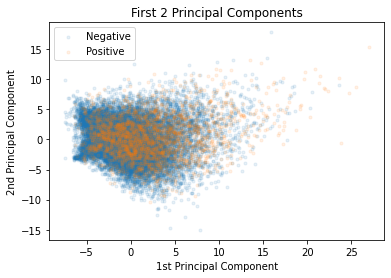

In [11]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(standard_data.iloc[:,1:])
plt.figure()
plt.scatter(pca_data[labels==0][:, 0], pca_data[labels==0][:, 1], alpha = 0.1, marker='.')
plt.scatter(pca_data[labels==1][:, 0], pca_data[labels==1][:, 1], alpha=0.1, marker='.')
plt.legend(["Negative", "Positive"])
plt.xlabel("1st Principal Component")
plt.ylabel("2nd Principal Component")
plt.title("First 2 Principal Components")
plt.show()

# PRE-DELIRIC

PRE-DELIRIC uses 10 main features, so to examine a baseline performance, we trained a logistic regressor using similar features.

First, recreated PRE-DELIRIC on mean dataset.

In [9]:
pre_data = data[["PatientStayID", "Age", "APACHEIVscore",	"max_BUN", "First24hrComa", "Metabolic", "UrgentAdmission", "Infection","FirstDayOpioids", "FirstDayBenzodiazepines", "FirstDayGeneralAnesthetics", "Surgery", "Medical", "Trauma", "Neurology/Neurosurgery"]]
pre_data = pre_data.astype(float)

pre_data

PatientStayID   Age  APACHEIVscore    max_BUN  First24hrComa  \
0           242154.0  46.0      77.000000  11.000000            0.0   
1           242290.0  75.0      77.000000  31.000000            0.0   
2           242474.0  52.0      64.000000  12.000000            0.0   
3           242505.0  90.0      78.000000  50.000000            0.0   
4           242714.0  78.0      57.094888  14.000000            0.0   
...              ...   ...            ...        ...            ...   
18300      3352193.0  19.0      57.094888   7.000000            0.0   
18301      3352331.0  75.0      48.000000  27.962207            0.0   
18302      3352964.0  85.0      75.000000  28.000000            0.0   
18303      3353044.0  52.0      41.000000   8.000000            0.0   
18304      3353077.0  60.0      36.000000  13.000000            0.0   

       Metabolic  UrgentAdmission  Infection  FirstDayOpioids  \
0            0.0              1.0        1.0              1.0   
1            0.0              1.0        1.0              1.0   
2            1.0              1.0        0.0              1.0   
3            0.0              1.0        1.0              1.0   
4            0.0              1.0        1.0              1.0   
...          ...              ...        ...              ...   
18300        1.0              1.0        1.0              1.0   
18301        0.0              1.0        0.0              1.0   
18302        0.0              1.0        0.0              1.0   
18303        0.0              1.0        0.0              0.0   
18304        0.0              1.0        1.0              1.0   

       FirstDayBenzodiazepines  FirstDayGeneralAnesthetics  Surgery  Medical  \
0                          0.0                         1.0      0.0      1.0   
1                          1.0                         0.0      0.0      1.0   
2                          1.0                         0.0      0.0      0.0   
3                          1.0                         0.0      0.0      1.0   
4                          0.0                         0.0      0.0      0.0   
...                        ...                         ...      ...      ...   
18300                      1.0                         1.0      0.0      0.0   
18301                      1.0                         0.0      0.0      0.0   
18302                      1.0                         0.0      0.0      1.0   
18303                      1.0                         0.0      0.0      0.0   
18304                      0.0                         0.0      0.0      0.0   

       Trauma  Neurology/Neurosurgery  
0         0.0                     0.0  
1         0.0                     0.0  
2         0.0                     1.0  
3         0.0                     0.0  
4         0.0                     1.0  
...       ...                     ...  
18300     1.0                     0.0  
18301     0.0                     1.0  
18302     0.0                     0.0  
18303     0.0                     1.0  
18304     0.0                     1.0  

[18305 rows x 15 columns]

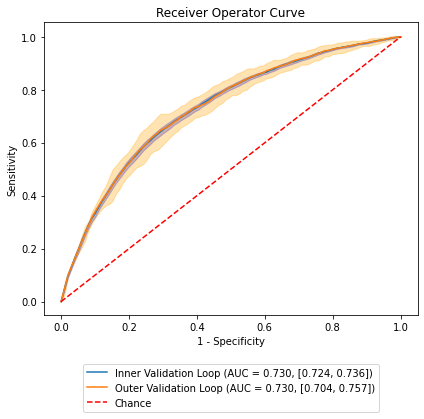

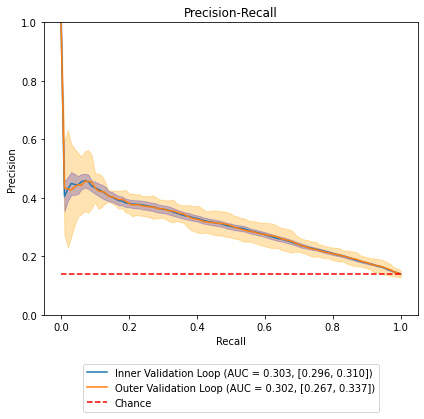

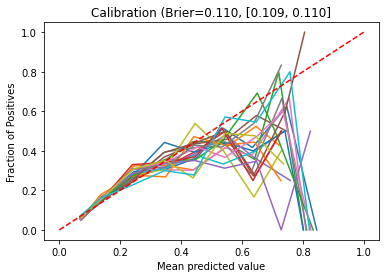

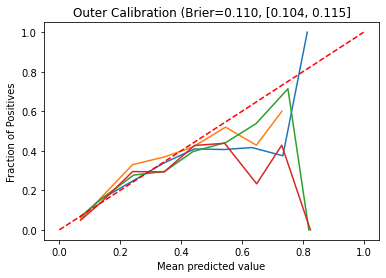

In [10]:
import statsmodels.api as sm
from scipy.stats import sem, t
from scipy import mean
from numpy import interp
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

calib_n_bins=10

inner_tprs = []
inner_aucs = []
outer_tprs = []
outer_aucs = []
inner_precision = []
outer_precision = []
inner_ap = []
outer_ap = []
iprob_true = []
iprob_pred = []
oprob_true = []
oprob_pred = []
ibrier = []
obrier = []

base_fpr = np.linspace(0, 1, 100)
base_recall = np.linspace(1, 0, 101)

for i in range(4):
    training_data, training_labels, testing_data, testing_labels,_,_ = split_table_to_sets(pre_data, numpy = False, set_num = i)
    training_data.insert(0, 'Intercept', 1)
    testing_data.insert(0, 'Intercept', 1)
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 5)
    for j, (cv_train, cv_test) in enumerate(cv.split(training_data, training_labels)):
        
        ######REPLACE CODE HERE######
        glm = sm.GLM(training_labels[cv_train], training_data.iloc[cv_train,:], family=sm.families.Binomial())
        results = glm.fit()
        predictions = results.predict(exog = training_data.iloc[cv_test,:])
        #############################
        
        if i == 0 and j == 0:
            backup_results = results

        inner_aucs.append(metrics.roc_auc_score(training_labels[cv_test], predictions))
        
        temp_fpr, temp_tpr, _ = metrics.roc_curve(training_labels[cv_test], predictions)
        temp_tpr = interp(base_fpr, temp_fpr, temp_tpr)
        temp_tpr[0] = 0.0
        inner_tprs.append(temp_tpr)


        temp_precision, temp_recall, _ = metrics.precision_recall_curve(
				training_labels[cv_test], predictions
			)
        f = interpolate.interp1d(temp_recall, temp_precision)
        temp_precision = f(base_recall)
        temp_precision[-1] = 1.0
        inner_precision.append(temp_precision)
        
        inner_ap.append(metrics.average_precision_score(training_labels[cv_test], predictions))
       
        prob_true, prob_pred = calibration_curve(
				training_labels[cv_test], predictions, n_bins=calib_n_bins
        )
        iprob_true.append(prob_true)
        iprob_pred.append(prob_pred)

        # Brier
        ibrier.append(
            metrics.brier_score_loss(training_labels[cv_test], predictions)
        )
        
    ######REPLACE CODE HERE######
    glm = sm.GLM(training_labels, training_data, family=sm.families.Binomial())
    results = glm.fit()
    predictions = results.predict(exog=testing_data)
    #############################
    if i == 0:
        backup_results = results
    
    outer_aucs.append(metrics.roc_auc_score(testing_labels, predictions))
    temp_fpr, temp_tpr, _ = metrics.roc_curve(testing_labels, predictions)
    temp_tpr = interp(base_fpr, temp_fpr, temp_tpr)
    temp_tpr[0] = 0.0
    outer_tprs.append(temp_tpr)

    outer_ap.append(metrics.average_precision_score(testing_labels, predictions))
    temp_precision, temp_recall, _ = metrics.precision_recall_curve(
			testing_labels, predictions
		)
    f = interpolate.interp1d(temp_recall, temp_precision)
    temp_precision = f(base_recall)
    temp_precision[-1] = 1.0
    outer_precision.append(temp_precision)

    prob_true, prob_pred = calibration_curve(
        testing_labels, predictions, n_bins=calib_n_bins
    )
    oprob_true.append(prob_true)
    oprob_pred.append(prob_pred)

    obrier.append(metrics.brier_score_loss(testing_labels, predictions))


predeliric = {
    "itpr": np.asarray(inner_tprs),
    "iauc": np.asarray(inner_aucs),
    "ip": np.asarray(inner_precision),
    "iap": np.asarray(inner_ap),
    "otpr": np.asarray(outer_tprs),
    "oauc": np.asarray(outer_aucs),
    "op": np.asarray(outer_precision),
    "oap": np.asarray(outer_ap),
    "iprobtrue": iprob_true,
    "iprobpred": iprob_pred,
    "oprobtrue": oprob_true,
    "oprobpred": oprob_pred,
    "ibrier": ibrier,
    "obrier": obrier
	}

name = "predeliric"
result_dict= predeliric

tpr = np.asarray(inner_tprs)
auc = np.asarray(inner_aucs)

testing_tpr = np.asarray(outer_tprs)
testing_auc = np.asarray(outer_aucs)

mid_tpr, up_tpr, low_tpr = compute_confidence(tpr)
mid_auc, up_auc, low_auc = compute_confidence(auc)

inner_mid_tpr, inner_up_tpr, inner_low_tpr = compute_confidence(tpr)
inner_mid_auc, inner_up_auc, inner_low_auc = compute_confidence(auc)
outer_mid_tpr, outer_up_tpr, outer_low_tpr = compute_confidence(testing_tpr)
outer_mid_auc, outer_up_auc, outer_low_auc = compute_confidence(testing_auc)

plt.figure(figsize=(6,6))
plt.plot(base_fpr, inner_mid_tpr, base_fpr, outer_mid_tpr, [0, 1], [0, 1], 'r--')
plt.fill_between(base_fpr, inner_low_tpr, inner_up_tpr, color='blue', alpha=0.3)
plt.fill_between(base_fpr, outer_low_tpr, outer_up_tpr, color='orange', alpha=0.3)
plt.xlabel("1 - Specificity") 
plt.ylabel("Sensitivity")
plt.title("Receiver Operator Curve")
plt.legend(("Inner Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(inner_mid_auc, inner_low_auc, inner_up_auc),
    "Outer Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_auc, outer_low_auc, outer_up_auc),
    'Chance'), loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_ROC.png".format(name), dpi = 'figure')
plt.show()

mid_precision, up_precision, low_precision = compute_confidence(result_dict["ip"])
mid_ap, up_ap, low_ap = compute_confidence(result_dict["iap"])
base_recall = np.linspace(1,0,101)

outer_mid_precision, outer_up_precision, outer_low_precision = compute_confidence(result_dict["op"])
outer_mid_ap, outer_up_ap, outer_low_ap = compute_confidence(result_dict["oap"])


plt.figure(figsize=(6,6))
plt.plot(base_recall, mid_precision, base_recall, outer_mid_precision, [0, 1], [pr_baseline, pr_baseline], 'r--')
plt.fill_between(base_recall, low_precision, up_precision, color='blue', alpha=0.3)
plt.fill_between(base_recall, outer_low_precision, outer_up_precision, color='orange', alpha=0.3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.ylim([0,1])
plt.legend(("Inner Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(mid_ap, low_ap, up_ap),
    "Outer Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_ap, outer_low_ap, outer_up_ap),
    'Chance'),
    loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_PR.png".format(name), dpi = 'figure')
plt.show()



mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["ibrier"]))

plt.figure()
for i in range(len(result_dict["iprobtrue"])):
    plt.plot(result_dict["iprobpred"][i], result_dict["iprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration.png".format(name), dpi = 'figure')
plt.show()

mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["obrier"]))

plt.figure()
for i in range(len(result_dict["oprobtrue"])):
    plt.plot(result_dict["oprobpred"][i], result_dict["oprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Outer Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration_outer.png".format(name), dpi = 'figure')
plt.show()

with open("../pickle/early_24hr_data/mean_unpruned/predeliric", "wb") as f:
    pickle.dump(predeliric, f)

# Logistic Regression

In [11]:
lr_calibrated = run_cross_validation(standard_data, "LogisticRegression", {"penalty" : ['l1'], "class_weight": ["balanced"], "max_iter" : [100], "C" : [0.0075, 0.01, 0.015, 0.02], "solver" : ["liblinear"]}, "from sklearn.linear_model import LogisticRegression", run_once = False, bayes=False, calibrate=True, outer_tuning=True, outer_labels=labels)

Fold 0:
{'C': 0.02, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Fold 1:
{'C': 0.015, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Fold 2:
{'C': 0.02, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Fold 3:
{'C': 0.015, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Liblinear failed to converge, increase the number of iterations.
Outer:
{'C': 0.02, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


In [12]:
with open("../pickle/early_24hr_data/mean_unpruned/lr", "wb") as f:
    pickle.dump(lr_calibrated, f)

In [10]:
with open("../pickle/early_24hr_data/mean_unpruned/lr", "rb") as f:
    lr_calibrated = pickle.load(f)

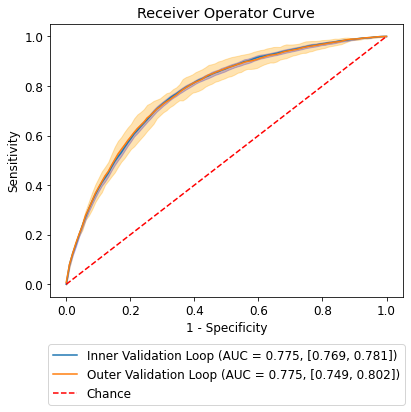

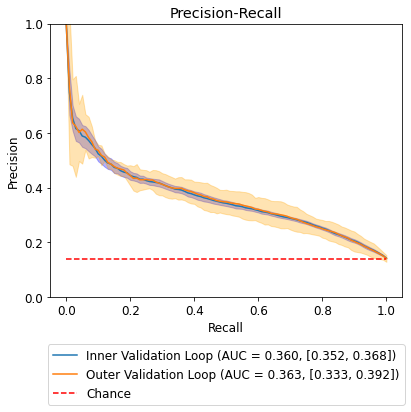

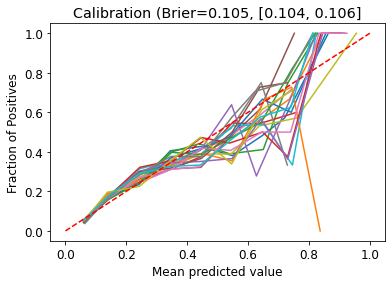

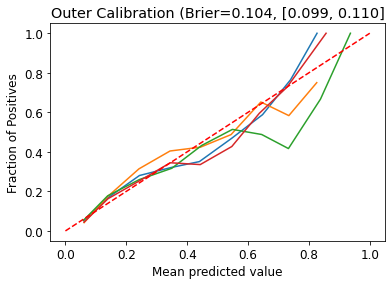

In [11]:
result_dict = lr_calibrated
name = "early_24hr_data/mean_unpruned/lr_calibrated"

base_fpr = np.linspace(0, 1, 100)

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

# ROC's
inner_mid_tpr, inner_up_tpr, inner_low_tpr = compute_confidence(result_dict["itpr"])
inner_mid_auc, inner_up_auc, inner_low_auc = compute_confidence(result_dict["iauc"])
outer_mid_tpr, outer_up_tpr, outer_low_tpr = compute_confidence(result_dict["otpr"])
outer_mid_auc, outer_up_auc, outer_low_auc = compute_confidence(result_dict["oauc"])
training_mid_tpr, training_up_tpr, training_low_tpr = compute_confidence(result_dict["ttpr"])
training_mid_auc, training_up_auc, training_low_auc = compute_confidence(result_dict["tauc"])

plt.figure(figsize=(6,6))
plt.plot(base_fpr, inner_mid_tpr, base_fpr, outer_mid_tpr, [0, 1], [0, 1], 'r--')
plt.fill_between(base_fpr, inner_low_tpr, inner_up_tpr, color='blue', alpha=0.3)
plt.fill_between(base_fpr, outer_low_tpr, outer_up_tpr, color='orange', alpha=0.3)
plt.xlabel("1 - Specificity") 
plt.ylabel("Sensitivity")
plt.title("Receiver Operator Curve")
plt.legend(("Inner Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(inner_mid_auc, inner_low_auc, inner_up_auc),
    "Outer Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_auc, outer_low_auc, outer_up_auc),
    'Chance'), loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_ROC.png".format(name), dpi = 'figure')
plt.show()

mid_precision, up_precision, low_precision = compute_confidence(result_dict["ip"])
mid_ap, up_ap, low_ap = compute_confidence(result_dict["iap"])
base_recall = np.linspace(1,0,101)

outer_mid_precision, outer_up_precision, outer_low_precision = compute_confidence(result_dict["op"])
outer_mid_ap, outer_up_ap, outer_low_ap = compute_confidence(result_dict["oap"])


plt.figure(figsize=(6,6))
plt.plot(base_recall, mid_precision, base_recall, outer_mid_precision, [0, 1], [pr_baseline, pr_baseline], 'r--')
plt.fill_between(base_recall, low_precision, up_precision, color='blue', alpha=0.3)
plt.fill_between(base_recall, outer_low_precision, outer_up_precision, color='orange', alpha=0.3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.ylim([0,1])
plt.legend(("Inner Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(mid_ap, low_ap, up_ap),
    "Outer Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_ap, outer_low_ap, outer_up_ap),
    'Chance'),
    loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_PR.png".format(name), dpi = 'figure')
plt.show()


mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["ibrier"]))

plt.figure()
for i in range(len(result_dict["iprobtrue"])):
    plt.plot(result_dict["iprobpred"][i], result_dict["iprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration.png".format(name), dpi = 'figure')
plt.show()

mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["obrier"]))

plt.figure()
for i in range(len(result_dict["oprobtrue"])):
    plt.plot(result_dict["oprobpred"][i], result_dict["oprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Outer Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration_outer.png".format(name), dpi = 'figure')
plt.show()

In [12]:
# Calibrated Mean Version

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

sel_ = SelectFromModel(LogisticRegression(**lr_calibrated["oparam"]))
sel_.fit(standard_data.iloc[:,1:], labels)

SelectFromModel(estimator=LogisticRegression(C=0.02, class_weight='balanced',
                                             penalty='l1', solver='liblinear'))

In [13]:
selected_feat = (data.iloc[:,1:]).columns[(sel_.get_support())]
print(len(selected_feat))
for i in range(len(selected_feat)):
    print(selected_feat[i])

155
Age
APACHEIVscore
UrgentAdmission
Infection
NumBeds
TeachingStatus
Gender
AdmitHeight
HistAICD
HistAngina
HistArrythmia
HistCABG
HistMI
HistPacemaker
HistPCI
HistPulmEmb
HistHeartTransp
HistValveDis
HistVenThromb
HistHypercalcemia
Histhyperthyroid
Histdiabetes
HistSteroid Use
HistHypersplenism
HistPUD
HistLiverTransp
HistAplasticAnemia
HistCancer
HistClottingDisorder
HistHemolyticAnemia
HistHypercoagulableCondition
HistOncology
HistMyeloproliferativeDisease
HistSickleCellDisease
HistDementia
HistIntracranialMass
HistNeuromuscularDis
HistStrokes
HistTIA
HistCOPD
HistRespiratoryFail
HistRestrictiveDis
HistLungTransp
HistRenalFail
HistRTA
24hrMeanVerbal
24hrMeanTotal
FirstDayAnticholinergicBronchodilators
FirstDayAntiemetics
FirstDayBarbiturates
FirstDayBenzodiazepines
FirstDayCarbapenems
FirstDayCephalosporins
FirstDayCrystalloidFluids
FirstDayDiuretics
FirstDayGeneralAnesthetics
FirstDayGlucoseElevating
FirstDayGlycopeptides
FirstDayH2Blockers
FirstDayInsulins
FirstDayLincomycins
Fi

In [16]:
import pickle as pickle
with open("../pickle/early_24hr_data/mean_unpruned/lr_calibrated_selected_feats.pkl", "wb") as f:
    pickle.dump(selected_feat, f)

In [14]:
dropped_feat = (data.iloc[:,1:]).columns[np.logical_not(sel_.get_support())]
print(len(dropped_feat))
for i in range(len(dropped_feat)):
    print(dropped_feat[i])

104
Metabolic
AdmitWeight
HistCHF
HistHypertension
HistPVD
HistCushing
Histhypothyroid
HistCirrhosis
HistChemotherapy
HistRadiationTherapy
HistImmuneSuppr
HistSeizures
HistAsthma
HistSarcoidosis
HistStoneDisease
HistNeurogenicBladd
HistRenalInsuff
HistRenalTransp
HistRheumatic
24hrMeanMotor
24hrMeanEyes
FirstDayAdrenergicBronchodilators
FirstDayaminoglycosides
FirstDayAnticholinergics
FirstDayAnticoagulants
FirstDayAntidiarrheals
FirstDayAntihistamines
FirstDayBetaBlockers
FirstDayCalciumChannelBlockers
FirstDayClassVAntiarrhythmics
FirstDayColloidFluids
FirstDayGlucocorticoids
FirstDayLaxatives
FirstDayMAOIAntidepressants
FirstDayMethylxanthines
FirstDayNSAIDs
FirstDayProtonPumpInhibitor
FirstDaySodiumChannelBlockers
FirstDayTetracyclicAntidepressants
FirstDayTetracyclines
FirstDayTricyclicAntidepressants
FirstDayVasodilators
24hr_sepsis
suspected_septic_shock
24hr_mean_temp
comorbidity_hypunc
comorbidity_diabc
comorbidity_ld
comorbidity_lymph
comorbidity_obes
comorbidity_wloss
sofa_c

In [18]:
import pickle as pickle
with open("../pickle/early_24hr_data/mean_unpruned/lr_calibrated_dropped_feats.pkl", "wb") as f:
    pickle.dump(dropped_feat, f)

In [19]:
# Coefficients
clf = LogisticRegression(**lr_calibrated["oparam"])
clf.fit(standard_data.iloc[:,1:], labels)
# Visualizing Coefficients
sorted_selected_feat = data.iloc[:,1:].columns[np.argsort(-np.abs(clf.coef_))]
sorted_coeff = clf.coef_[0][np.argsort(-np.abs(clf.coef_))]

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


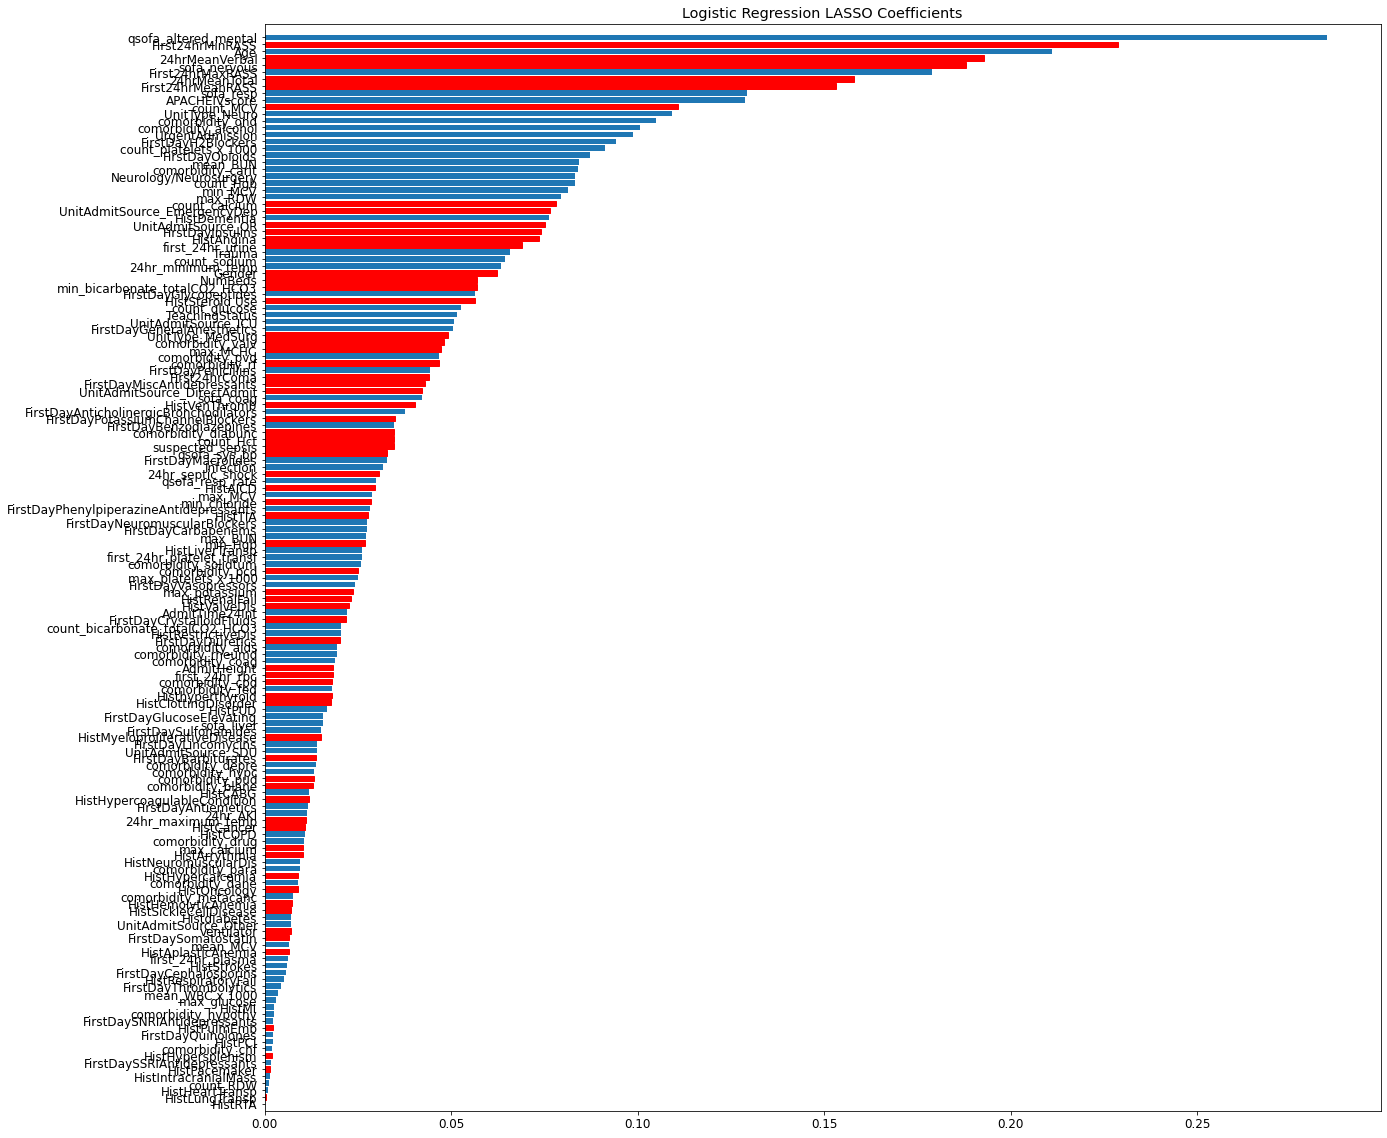

In [20]:
plt.figure(figsize=(20,20))
x = np.flip(np.arange(len(selected_feat)))
barlist = plt.barh(x, np.abs(sorted_coeff[0][:len(selected_feat)]))
plt.yticks(x, sorted_selected_feat[0][:len(selected_feat)])
plt.ylim(-1, len(selected_feat)+1)
temp = np.where(sorted_coeff[0][:len(selected_feat)] < 0)[0]
for i in temp:
    barlist[i].set_color('r')
plt.title("Logistic Regression LASSO Coefficients")
plt.show()

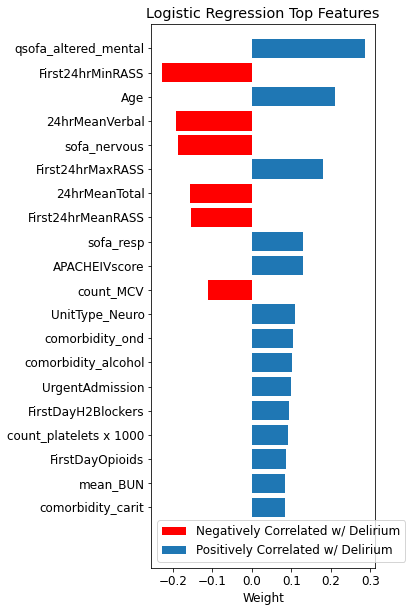

In [21]:
x = np.flip(np.arange(20))
plt.figure(figsize=(4,10))
temp = np.where(sorted_coeff[0][:20] < 0)[0]
plt.barh(x[temp], (sorted_coeff[0][temp]), color='r')
temp = np.where(sorted_coeff[0][:20] >= 0)[0]
plt.barh(x[temp], (sorted_coeff[0][temp]))

temp = sorted_selected_feat[0][:20]
temp_x = ["Mean Verbal GCS",
        "Age",
        "APACHE IV Score",
        "Teaching Status",
        "24hr Max Temp",
        "Alcohol Abuse",
        "Mean Eyes GCS",
        "Neurology",
        "24hr Min MCV",
        "First Day H2 Blockers",
        "Coma",
        "Weight Loss",
        "Suspected Sepsis",
        "Admitted from ICU",
        "Step Down Unit",
        "History of Dementia",
        "24hr Glycopeptides",
        "2hr AKI",
        "24hr Max BUN",
        "24hr Max RDW"]

plt.yticks(x, temp)
plt.ylim(-2.5, 20)

plt.title("Logistic Regression Top Features")
plt.legend(["Negatively Correlated w/ Delirium", "Positively Correlated w/ Delirium"])
#plt.tight_layout()
plt.xlabel("Weight")
plt.savefig('../figures/early_24hr_data/mean_unpruned/lr_calibrated_coefficients_short.png', dpi=500,bbox_inches = "tight")
plt.show()

In [12]:
with open("../pickle/early_24hr_data/mean_unpruned/lr_calibrated_dropped_feats.pkl", "rb") as f:
	dropped_feat = pickle.load(f)

data_pruned = data.drop(dropped_feat, axis=1)
data_pruned

PatientStayID   Age  APACHEIVscore  UrgentAdmission  Infection  \
0           242154.0  46.0      77.000000              1.0        1.0   
1           242290.0  75.0      77.000000              1.0        1.0   
2           242474.0  52.0      64.000000              1.0        0.0   
3           242505.0  90.0      78.000000              1.0        1.0   
4           242714.0  78.0      57.094888              1.0        1.0   
...              ...   ...            ...              ...        ...   
18300      3352193.0  19.0      57.094888              1.0        1.0   
18301      3352331.0  75.0      48.000000              1.0        0.0   
18302      3352964.0  85.0      75.000000              1.0        0.0   
18303      3353044.0  52.0      41.000000              1.0        0.0   
18304      3353077.0  60.0      36.000000              1.0        1.0   

       NumBeds  TeachingStatus  Gender  AdmitHeight  HistAICD  ...  \
0          4.0             0.0     1.0       157.48       0.0  ...   
1          4.0             0.0     1.0       165.10       0.0  ...   
2          4.0             0.0     0.0       177.80       0.0  ...   
3          4.0             0.0     1.0       165.10       0.0  ...   
4          4.0             0.0     0.0       182.90       0.0  ...   
...        ...             ...     ...          ...       ...  ...   
18300      4.0             0.0     1.0       157.50       0.0  ...   
18301      2.0             0.0     1.0       167.60       0.0  ...   
18302      2.0             0.0     1.0       162.00       0.0  ...   
18303      2.0             0.0     0.0       175.00       0.0  ...   
18304      4.0             0.0     1.0       165.10       0.0  ...   

       Neurology/Neurosurgery  AdmitTime24Int  UnitType_MedSurg  \
0                         0.0         62820.0               1.0   
1                         0.0         61200.0               1.0   
2                         1.0         55260.0               1.0   
3                         0.0         85860.0               1.0   
4                         1.0         65880.0               1.0   
...                       ...             ...               ...   
18300                     0.0         27420.0               0.0   
18301                     1.0         85680.0               1.0   
18302                     0.0         61980.0               1.0   
18303                     1.0         20340.0               1.0   
18304                     1.0         15840.0               0.0   

       UnitType_Neuro  UnitAdmitSource_DirectAdmit  \
0                 0.0                          1.0   
1                 0.0                          1.0   
2                 0.0                          0.0   
3                 0.0                          0.0   
4                 0.0                          1.0   
...               ...                          ...   
18300             1.0                          0.0   
18301             0.0                          0.0   
18302             0.0                          0.0   
18303             0.0                          0.0   
18304             1.0                          0.0   

       UnitAdmitSource_EmergencyDep  UnitAdmitSource_ICU  UnitAdmitSource_OR  \
0                               0.0                  0.0                 0.0   
1                               0.0                  0.0                 0.0   
2                               1.0                  0.0                 0.0   
3                               1.0                  0.0                 0.0   
4                               0.0                  0.0                 0.0   
...                             ...                  ...                 ...   
18300                           1.0                  0.0                 0.0   
18301                           1.0                  0.0                 0.0   
18302                           0.0                  0.0                 0.0   
18303                           0.0

In [10]:
standard_data_pruned = standard_data.drop(dropped_feat, axis=1)
standard_data_pruned

PatientStayID       Age  APACHEIVscore  UrgentAdmission  Infection  \
0           242154.0 -1.058208   8.522392e-01         0.401393   1.701133   
1           242290.0  0.693917   8.522392e-01         0.401393   1.701133   
2           242474.0 -0.695700   2.956430e-01         0.401393  -0.587844   
3           242505.0  1.600189   8.950543e-01         0.401393   1.701133   
4           242714.0  0.875172  -3.042195e-16         0.401393   1.701133   
...              ...       ...            ...              ...        ...   
18300      3352193.0 -2.689498  -3.042195e-16         0.401393   1.701133   
18301      3352331.0  0.693917  -3.893985e-01         0.401393  -0.587844   
18302      3352964.0  1.298098   7.666090e-01         0.401393  -0.587844   
18303      3353044.0 -0.695700  -6.891041e-01         0.401393  -0.587844   
18304      3353077.0 -0.212355  -9.031796e-01         0.401393   1.701133   

        NumBeds  TeachingStatus    Gender  AdmitHeight  HistAICD  ...  \
0      0.887051       -0.718553  1.052338    -0.719153 -0.159656  ...   
1      0.887051       -0.718553  1.052338    -0.237013 -0.159656  ...   
2      0.887051       -0.718553 -0.950265     0.566555 -0.159656  ...   
3      0.887051       -0.718553  1.052338    -0.237013 -0.159656  ...   
4      0.887051       -0.718553 -0.950265     0.889247 -0.159656  ...   
...         ...             ...       ...          ...       ...  ...   
18300  0.887051       -0.718553  1.052338    -0.717888 -0.159656  ...   
18301 -1.694738       -0.718553  1.052338    -0.078830 -0.159656  ...   
18302 -1.694738       -0.718553  1.052338    -0.433159 -0.159656  ...   
18303 -1.694738       -0.718553 -0.950265     0.389390 -0.159656  ...   
18304  0.887051       -0.718553  1.052338    -0.237013 -0.159656  ...   

       Neurology/Neurosurgery  AdmitTime24Int  UnitType_MedSurg  \
0                   -0.430050        0.646401          0.747352   
1                   -0.430050        0.583508          0.747352   
2                    2.325311        0.352900          0.747352   
3                   -0.430050        1.540879          0.747352   
4                    2.325311        0.765199          0.747352   
...                       ...             ...               ...   
18300               -0.430050       -0.727927         -1.338057   
18301                2.325311        1.533891          0.747352   
18302               -0.430050        0.613790          0.747352   
18303                2.325311       -1.002793          0.747352   
18304                2.325311       -1.177496         -1.338057   

       UnitType_Neuro  UnitAdmitSource_DirectAdmit  \
0           -0.349346                     4.029435   
1           -0.349346                     4.029435   
2           -0.349346                    -0.248174   
3           -0.349346                    -0.248174   
4           -0.349346                     4.029435   
...               ...                          ...   
18300        2.862494                    -0.248174   
18301       -0.349346                    -0.248174   
18302       -0.349346                    -0.248174   
18303       -0.349346                    -0.248174   
18304        2.862494                    -0.248174   

       UnitAdmitSource_EmergencyDep  UnitAdmitSource_ICU  UnitAdmitSource_OR  \
0                         -0.986704            -0.146381           -0.307465   
1                         -0.986704            -0.146381           -0.307465   
2                          1.013475            -0.146381           -0.307465   
3                          1.013475            -0.146381           -0.307465   
4                         -0.986704            -0.146381           -0.307465   
...                             ...                  ...                 ...   
18300                      1.013475            -0.146381           -0.307465   
18301                      1.013475            -0.146381           -0.307465   
18302                     -0.98

# Random Forest

Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator LabelEncoder from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator _SigmoidCalibration from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator CalibratedClassifierCV from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


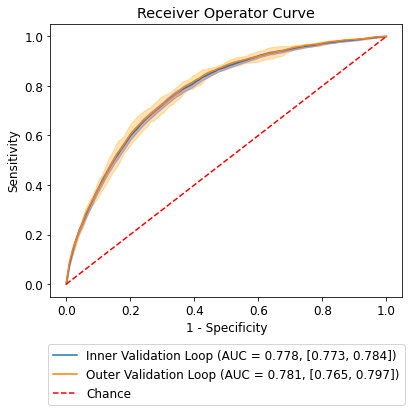

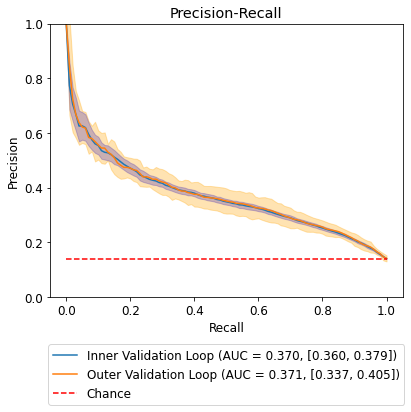

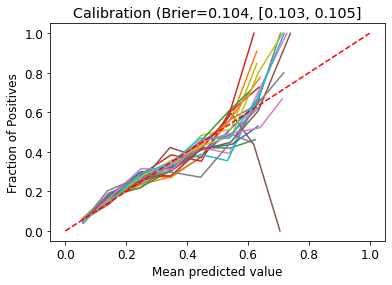

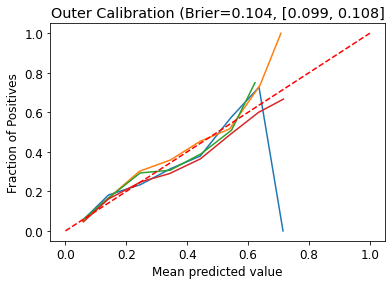

{'ccp_alpha': 0.0003552166981589302, 'class_weight': 'balanced', 'max_depth': 40, 'max_features': 0.12939514257245893, 'max_samples': 0.6348147620691598, 'min_samples_leaf': 7, 'min_samples_split': 6, 'n_estimators': 500}


In [37]:
with open("../pickle/early_24hr_data/mean_unpruned/rf", "rb") as f:
    rf_result = pickle.load(f)

result_dict = rf_result
name = "early_24hr_data/mean_unpruned/rf"

base_fpr = np.linspace(0, 1, 100)

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

# ROC's
inner_mid_tpr, inner_up_tpr, inner_low_tpr = compute_confidence(result_dict["itpr"])
inner_mid_auc, inner_up_auc, inner_low_auc = compute_confidence(result_dict["iauc"])
outer_mid_tpr, outer_up_tpr, outer_low_tpr = compute_confidence(result_dict["otpr"])
outer_mid_auc, outer_up_auc, outer_low_auc = compute_confidence(result_dict["oauc"])
training_mid_tpr, training_up_tpr, training_low_tpr = compute_confidence(result_dict["ttpr"])
training_mid_auc, training_up_auc, training_low_auc = compute_confidence(result_dict["tauc"])

plt.figure(figsize=(6,6))
plt.plot(base_fpr, inner_mid_tpr, base_fpr, outer_mid_tpr, [0, 1], [0, 1], 'r--')
plt.fill_between(base_fpr, inner_low_tpr, inner_up_tpr, color='blue', alpha=0.3)
plt.fill_between(base_fpr, outer_low_tpr, outer_up_tpr, color='orange', alpha=0.3)
plt.xlabel("1 - Specificity") 
plt.ylabel("Sensitivity")
plt.title("Receiver Operator Curve")
plt.legend(("Inner Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(inner_mid_auc, inner_low_auc, inner_up_auc),
    "Outer Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_auc, outer_low_auc, outer_up_auc),
    'Chance'), loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_ROC.png".format(name), dpi = 'figure')
plt.show()

mid_precision, up_precision, low_precision = compute_confidence(result_dict["ip"])
mid_ap, up_ap, low_ap = compute_confidence(result_dict["iap"])
base_recall = np.linspace(1,0,101)

outer_mid_precision, outer_up_precision, outer_low_precision = compute_confidence(result_dict["op"])
outer_mid_ap, outer_up_ap, outer_low_ap = compute_confidence(result_dict["oap"])


plt.figure(figsize=(6,6))
plt.plot(base_recall, mid_precision, base_recall, outer_mid_precision, [0, 1], [pr_baseline, pr_baseline], 'r--')
plt.fill_between(base_recall, low_precision, up_precision, color='blue', alpha=0.3)
plt.fill_between(base_recall, outer_low_precision, outer_up_precision, color='orange', alpha=0.3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.ylim([0,1])
plt.legend(("Inner Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(mid_ap, low_ap, up_ap),
    "Outer Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_ap, outer_low_ap, outer_up_ap),
    'Chance'),
    loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_PR.png".format(name), dpi = 'figure')
plt.show()



mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["ibrier"]))

plt.figure()
for i in range(len(result_dict["iprobtrue"])):
    plt.plot(result_dict["iprobpred"][i], result_dict["iprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration.png".format(name), dpi = 'figure')
plt.show()

mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["obrier"]))

plt.figure()
for i in range(len(result_dict["oprobtrue"])):
    plt.plot(result_dict["oprobpred"][i], result_dict["oprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Outer Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration_outer.png".format(name), dpi = 'figure')
plt.show()


print(rf_result["oparam"])

Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator LabelEncoder from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator _SigmoidCalibration from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator CalibratedClassifierCV from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


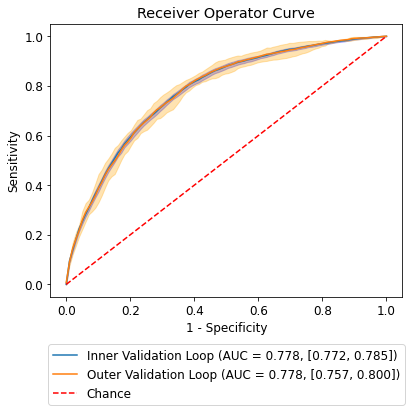

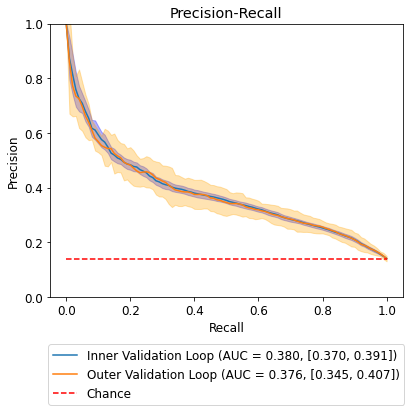

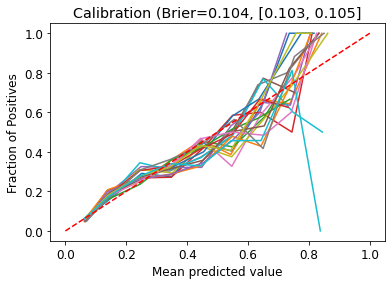

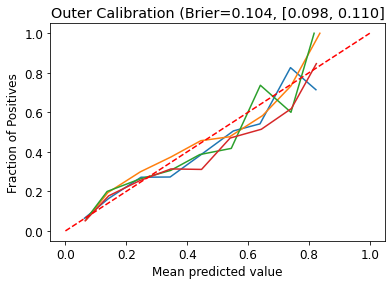

In [11]:
with open("../pickle/early_24hr_data/mean_pruned/rf_unbalanced", "rb") as f:
    rf_result = pickle.load(f)

result_dict = rf_result
name = "early_24hr_data/mean_pruned/rf"


base_fpr = np.linspace(0, 1, 100)

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

# ROC's
inner_mid_tpr, inner_up_tpr, inner_low_tpr = compute_confidence(result_dict["itpr"])
inner_mid_auc, inner_up_auc, inner_low_auc = compute_confidence(result_dict["iauc"])
outer_mid_tpr, outer_up_tpr, outer_low_tpr = compute_confidence(result_dict["otpr"])
outer_mid_auc, outer_up_auc, outer_low_auc = compute_confidence(result_dict["oauc"])
training_mid_tpr, training_up_tpr, training_low_tpr = compute_confidence(result_dict["ttpr"])
training_mid_auc, training_up_auc, training_low_auc = compute_confidence(result_dict["tauc"])

plt.figure(figsize=(6,6))
plt.plot(base_fpr, inner_mid_tpr, base_fpr, outer_mid_tpr, [0, 1], [0, 1], 'r--')
plt.fill_between(base_fpr, inner_low_tpr, inner_up_tpr, color='blue', alpha=0.3)
plt.fill_between(base_fpr, outer_low_tpr, outer_up_tpr, color='orange', alpha=0.3)
plt.xlabel("1 - Specificity") 
plt.ylabel("Sensitivity")
plt.title("Receiver Operator Curve")
plt.legend(("Inner Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(inner_mid_auc, inner_low_auc, inner_up_auc),
    "Outer Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_auc, outer_low_auc, outer_up_auc),
    'Chance'), loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_ROC.png".format(name), dpi = 'figure')
plt.show()

mid_precision, up_precision, low_precision = compute_confidence(result_dict["ip"])
mid_ap, up_ap, low_ap = compute_confidence(result_dict["iap"])
base_recall = np.linspace(1,0,101)

outer_mid_precision, outer_up_precision, outer_low_precision = compute_confidence(result_dict["op"])
outer_mid_ap, outer_up_ap, outer_low_ap = compute_confidence(result_dict["oap"])


plt.figure(figsize=(6,6))
plt.plot(base_recall, mid_precision, base_recall, outer_mid_precision, [0, 1], [pr_baseline, pr_baseline], 'r--')
plt.fill_between(base_recall, low_precision, up_precision, color='blue', alpha=0.3)
plt.fill_between(base_recall, outer_low_precision, outer_up_precision, color='orange', alpha=0.3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.ylim([0,1])
plt.legend(("Inner Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(mid_ap, low_ap, up_ap),
    "Outer Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_ap, outer_low_ap, outer_up_ap),
    'Chance'),
    loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_PR.png".format(name), dpi = 'figure')
plt.show()


mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["ibrier"]))

plt.figure()
for i in range(len(result_dict["iprobtrue"])):
    plt.plot(result_dict["iprobpred"][i], result_dict["iprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration.png".format(name), dpi = 'figure')
plt.show()

mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["obrier"]))

plt.figure()
for i in range(len(result_dict["oprobtrue"])):
    plt.plot(result_dict["oprobpred"][i], result_dict["oprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Outer Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration_outer.png".format(name), dpi = 'figure')
plt.show()

In [13]:
print(result_dict["oparam"])

{'ccp_alpha': 0.00013488757502313955, 'max_depth': 50, 'max_features': 0.06307313831160079, 'max_samples': 0.8211980594548445, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 750}


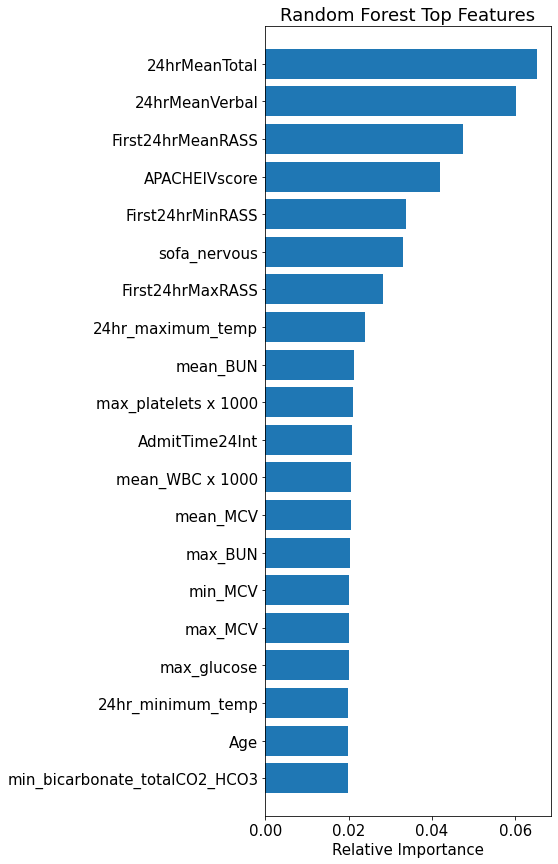

In [12]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**result_dict["oparam"])
clf.fit(data_pruned.iloc[:,1:], labels)

importances = clf.feature_importances_
sorted_selected_feat = data_pruned.iloc[:,1:].columns[np.argsort(-np.abs(importances))]
sorted_coeff = importances[np.argsort(-np.abs(importances))]
random_forest_sorted_selected_feat = np.copy(sorted_selected_feat)

num_features=20
x = np.flip(np.arange(len(sorted_selected_feat[:num_features])))

plt.figure(figsize=(8,12))
plt.rcParams.update({'font.size': 15})
barlist = plt.barh(x, np.abs(sorted_coeff[:num_features]))
temp = sorted_selected_feat[:20]
temp_x = ["Mean Verbal GCS",
"Mean Total GCS",
"APACHE IV Score",
"Mean Motor GCS",
"Mean Eyes GCS",
"Admit Weight",
"Mean Sodium",
"Age",
"Min Sodium",
"Unit Admit Time",
"Admit Time",
"Max RBC",
"Mean Bicarbonate",
"Admit Height",
"Max Sodium",
"Min Bicarbonate",
"Mean BUN",
"Mean RBC",
"Min BUN",
"Min Glucose"
]
plt.yticks(x, temp)
plt.ylim(-1, num_features)
plt.title("Random Forest Top Features")
plt.tight_layout()
plt.xlabel("Relative Importance")
plt.savefig("../figures/{}_feature_importance.png".format(name), bbox_inches = "tight")
plt.show()

# Stacked

Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator LabelEncoder from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator StackingClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


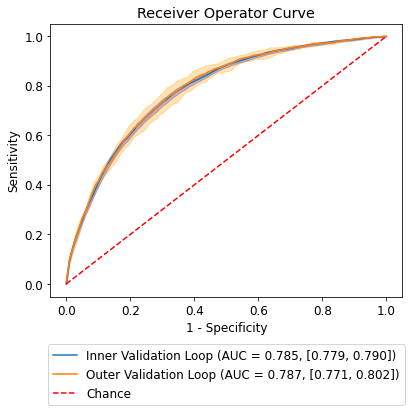

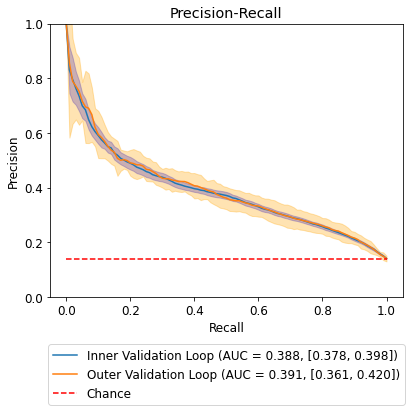

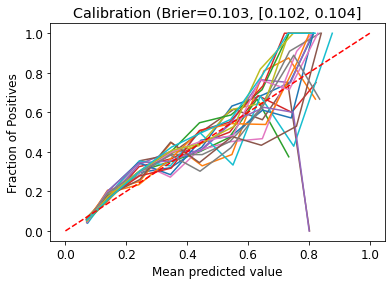

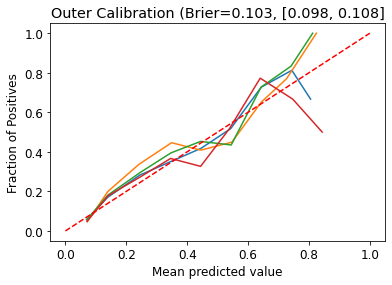

In [40]:
import pickle
with open("../pickle/early_24hr_data/mean_unpruned/stacked", "rb") as f:
    stacked_result = pickle.load(f)

result_dict = stacked_result
name = "early_24hr_data/mean_unpruned/stacked"


base_fpr = np.linspace(0, 1, 100)

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

# ROC's
inner_mid_tpr, inner_up_tpr, inner_low_tpr = compute_confidence(result_dict["itpr"])
inner_mid_auc, inner_up_auc, inner_low_auc = compute_confidence(result_dict["iauc"])
outer_mid_tpr, outer_up_tpr, outer_low_tpr = compute_confidence(result_dict["otpr"])
outer_mid_auc, outer_up_auc, outer_low_auc = compute_confidence(result_dict["oauc"])
training_mid_tpr, training_up_tpr, training_low_tpr = compute_confidence(result_dict["ttpr"])
training_mid_auc, training_up_auc, training_low_auc = compute_confidence(result_dict["tauc"])

plt.figure(figsize=(6,6))
plt.plot(base_fpr, inner_mid_tpr, base_fpr, outer_mid_tpr, [0, 1], [0, 1], 'r--')
plt.fill_between(base_fpr, inner_low_tpr, inner_up_tpr, color='blue', alpha=0.3)
plt.fill_between(base_fpr, outer_low_tpr, outer_up_tpr, color='orange', alpha=0.3)
plt.xlabel("1 - Specificity") 
plt.ylabel("Sensitivity")
plt.title("Receiver Operator Curve")
plt.legend(("Inner Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(inner_mid_auc, inner_low_auc, inner_up_auc),
    "Outer Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_auc, outer_low_auc, outer_up_auc),
    'Chance'), loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_ROC.png".format(name), dpi = 'figure')
plt.show()

mid_precision, up_precision, low_precision = compute_confidence(result_dict["ip"])
mid_ap, up_ap, low_ap = compute_confidence(result_dict["iap"])
base_recall = np.linspace(1,0,101)

outer_mid_precision, outer_up_precision, outer_low_precision = compute_confidence(result_dict["op"])
outer_mid_ap, outer_up_ap, outer_low_ap = compute_confidence(result_dict["oap"])


plt.figure(figsize=(6,6))
plt.plot(base_recall, mid_precision, base_recall, outer_mid_precision, [0, 1], [pr_baseline, pr_baseline], 'r--')
plt.fill_between(base_recall, low_precision, up_precision, color='blue', alpha=0.3)
plt.fill_between(base_recall, outer_low_precision, outer_up_precision, color='orange', alpha=0.3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.ylim([0,1])
plt.legend(("Inner Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(mid_ap, low_ap, up_ap),
    "Outer Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_ap, outer_low_ap, outer_up_ap),
    'Chance'),
    loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_PR.png".format(name), dpi = 'figure')
plt.show()



mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["ibrier"]))

plt.figure()
for i in range(len(result_dict["iprobtrue"])):
    plt.plot(result_dict["iprobpred"][i], result_dict["iprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration.png".format(name), dpi = 'figure')
plt.show()

mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["obrier"]))

plt.figure()
for i in range(len(result_dict["oprobtrue"])):
    plt.plot(result_dict["oprobpred"][i], result_dict["oprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Outer Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration_outer.png".format(name), dpi = 'figure')
plt.show()


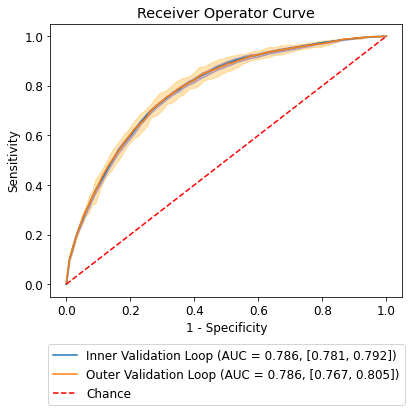

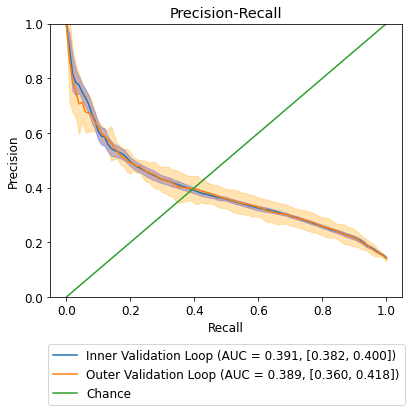

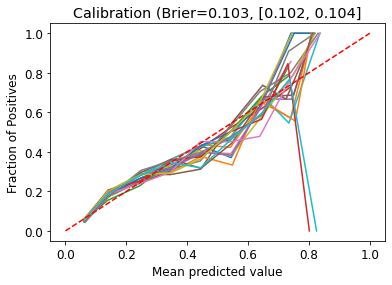

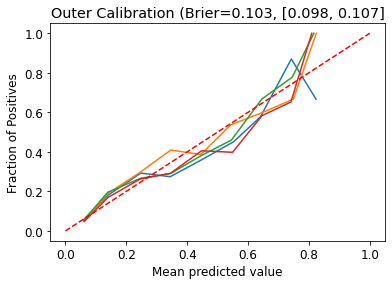

In [3]:
# import pickle
# with open("../pickle/early_24hr_data/mean_pruned/stacked", "rb") as f:
#     stacked_result = pickle.load(f)

result_dict = stacked_result
name = "early_24hr_data/mean_pruned/stacked"


base_fpr = np.linspace(0, 1, 100)

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

# ROC's
inner_mid_tpr, inner_up_tpr, inner_low_tpr = compute_confidence(result_dict["itpr"])
inner_mid_auc, inner_up_auc, inner_low_auc = compute_confidence(result_dict["iauc"])
outer_mid_tpr, outer_up_tpr, outer_low_tpr = compute_confidence(result_dict["otpr"])
outer_mid_auc, outer_up_auc, outer_low_auc = compute_confidence(result_dict["oauc"])
training_mid_tpr, training_up_tpr, training_low_tpr = compute_confidence(result_dict["ttpr"])
training_mid_auc, training_up_auc, training_low_auc = compute_confidence(result_dict["tauc"])

plt.figure(figsize=(6,6))
plt.plot(base_fpr, inner_mid_tpr, base_fpr, outer_mid_tpr, [0, 1], [0, 1], 'r--')
plt.fill_between(base_fpr, inner_low_tpr, inner_up_tpr, color='blue', alpha=0.3)
plt.fill_between(base_fpr, outer_low_tpr, outer_up_tpr, color='orange', alpha=0.3)
plt.xlabel("1 - Specificity") 
plt.ylabel("Sensitivity")
plt.title("Receiver Operator Curve")
plt.legend(("Inner Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(inner_mid_auc, inner_low_auc, inner_up_auc),
    "Outer Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_auc, outer_low_auc, outer_up_auc),
    'Chance'), loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_ROC.png".format(name), dpi = 'figure')
plt.show()

mid_precision, up_precision, low_precision = compute_confidence(result_dict["ip"])
mid_ap, up_ap, low_ap = compute_confidence(result_dict["iap"])
base_recall = np.linspace(1,0,101)

outer_mid_precision, outer_up_precision, outer_low_precision = compute_confidence(result_dict["op"])
outer_mid_ap, outer_up_ap, outer_low_ap = compute_confidence(result_dict["oap"])


plt.figure(figsize=(6,6))
plt.plot(base_recall, mid_precision, base_recall, outer_mid_precision, [0, 1])
plt.fill_between(base_recall, low_precision, up_precision, color='blue', alpha=0.3)
plt.fill_between(base_recall, outer_low_precision, outer_up_precision, color='orange', alpha=0.3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.ylim([0,1])
plt.legend(("Inner Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(mid_ap, low_ap, up_ap),
    "Outer Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_ap, outer_low_ap, outer_up_ap),
    'Chance'),
    loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_PR.png".format(name), dpi = 'figure')
plt.show()



mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["ibrier"]))

plt.figure()
for i in range(len(result_dict["iprobtrue"])):
    plt.plot(result_dict["iprobpred"][i], result_dict["iprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration.png".format(name), dpi = 'figure')
plt.show()

mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["obrier"]))

plt.figure()
for i in range(len(result_dict["oprobtrue"])):
    plt.plot(result_dict["oprobpred"][i], result_dict["oprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Outer Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration_outer.png".format(name), dpi = 'figure')
plt.show()


# CatBoost

In [24]:
catboost_result = run_parallel_cross_validation(data, 
												"CatBoostClassifier",
												{"n_estimators": 3000},
												"from catboost import CatBoostClassifier",
												run_once = True,
												bayes=False,
												calibrate=True,
												n_jobs=2,
												run_id=5,
												outer_tuning=True,
												outer_labels=labels)


Inner Validation Complete


In [25]:
with open("../pickle/early_24hr_data/mean_unpruned/catboost", "wb") as f:
    pickle.dump(catboost_result, f)

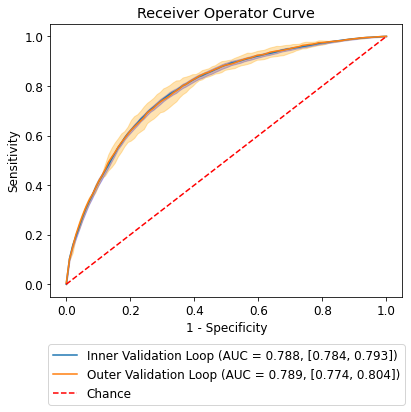

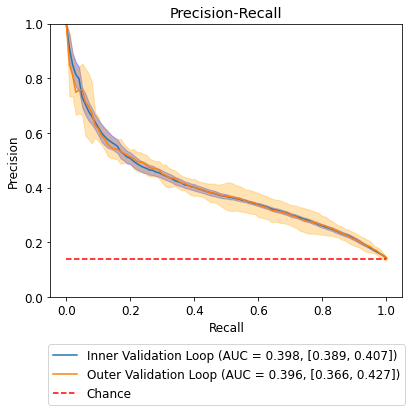

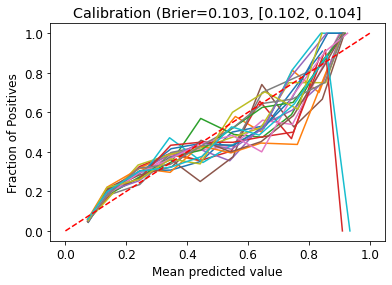

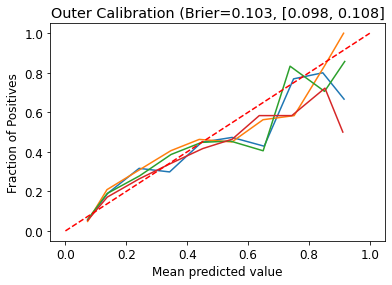

In [26]:
import pickle
with open("../pickle/early_24hr_data/mean_unpruned/catboost", "rb") as f:
    catboost_result = pickle.load(f)


result_dict = catboost_result
name = "/early_24hr_data/mean_unpruned/catboost"

base_fpr = np.linspace(0, 1, 100)

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

# ROC's
inner_mid_tpr, inner_up_tpr, inner_low_tpr = compute_confidence(result_dict["itpr"])
inner_mid_auc, inner_up_auc, inner_low_auc = compute_confidence(result_dict["iauc"])
outer_mid_tpr, outer_up_tpr, outer_low_tpr = compute_confidence(result_dict["otpr"])
outer_mid_auc, outer_up_auc, outer_low_auc = compute_confidence(result_dict["oauc"])
training_mid_tpr, training_up_tpr, training_low_tpr = compute_confidence(result_dict["ttpr"])
training_mid_auc, training_up_auc, training_low_auc = compute_confidence(result_dict["tauc"])

plt.figure(figsize=(6,6))
plt.plot(base_fpr, inner_mid_tpr, base_fpr, outer_mid_tpr, [0, 1], [0, 1], 'r--')
plt.fill_between(base_fpr, inner_low_tpr, inner_up_tpr, color='blue', alpha=0.3)
plt.fill_between(base_fpr, outer_low_tpr, outer_up_tpr, color='orange', alpha=0.3)
plt.xlabel("1 - Specificity") 
plt.ylabel("Sensitivity")
plt.title("Receiver Operator Curve")
plt.legend(("Inner Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(inner_mid_auc, inner_low_auc, inner_up_auc),
    "Outer Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_auc, outer_low_auc, outer_up_auc),
    'Chance'), loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_ROC.png".format(name), dpi = 'figure')
plt.show()

mid_precision, up_precision, low_precision = compute_confidence(result_dict["ip"])
mid_ap, up_ap, low_ap = compute_confidence(result_dict["iap"])
base_recall = np.linspace(1,0,101)

outer_mid_precision, outer_up_precision, outer_low_precision = compute_confidence(result_dict["op"])
outer_mid_ap, outer_up_ap, outer_low_ap = compute_confidence(result_dict["oap"])


plt.figure(figsize=(6,6))
plt.plot(base_recall, mid_precision, base_recall, outer_mid_precision, [0, 1], [pr_baseline, pr_baseline], 'r--')
plt.fill_between(base_recall, low_precision, up_precision, color='blue', alpha=0.3)
plt.fill_between(base_recall, outer_low_precision, outer_up_precision, color='orange', alpha=0.3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.ylim([0,1])
plt.legend(("Inner Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(mid_ap, low_ap, up_ap),
    "Outer Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_ap, outer_low_ap, outer_up_ap),
    'Chance'),
    loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_PR.png".format(name), dpi = 'figure')
plt.show()



mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["ibrier"]))

plt.figure()
for i in range(len(result_dict["iprobtrue"])):
    plt.plot(result_dict["iprobpred"][i], result_dict["iprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration.png".format(name), dpi = 'figure')
plt.show()

mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["obrier"]))

plt.figure()
for i in range(len(result_dict["oprobtrue"])):
    plt.plot(result_dict["oprobpred"][i], result_dict["oprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Outer Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration_outer.png".format(name), dpi = 'figure')
plt.show()


ining: 15.2s
2628:	learn: 0.2149595	total: 1m 47s	remaining: 15.2s
2629:	learn: 0.2149198	total: 1m 47s	remaining: 15.1s
2630:	learn: 0.2148765	total: 1m 47s	remaining: 15.1s
2631:	learn: 0.2148198	total: 1m 47s	remaining: 15.1s
2632:	learn: 0.2148018	total: 1m 47s	remaining: 15s
2633:	learn: 0.2147646	total: 1m 47s	remaining: 15s
2634:	learn: 0.2147124	total: 1m 47s	remaining: 14.9s
2635:	learn: 0.2146958	total: 1m 47s	remaining: 14.9s
2636:	learn: 0.2146746	total: 1m 47s	remaining: 14.9s
2637:	learn: 0.2146370	total: 1m 48s	remaining: 14.8s
2638:	learn: 0.2146006	total: 1m 48s	remaining: 14.8s
2639:	learn: 0.2145708	total: 1m 48s	remaining: 14.7s
2640:	learn: 0.2145301	total: 1m 48s	remaining: 14.7s
2641:	learn: 0.2144920	total: 1m 48s	remaining: 14.7s
2642:	learn: 0.2144723	total: 1m 48s	remaining: 14.6s
2643:	learn: 0.2144382	total: 1m 48s	remaining: 14.6s
2644:	learn: 0.2143944	total: 1m 48s	remaining: 14.5s
2645:	learn: 0.2143608	total: 1m 48s	remaining: 14.5s
2646:	learn: 0.2143

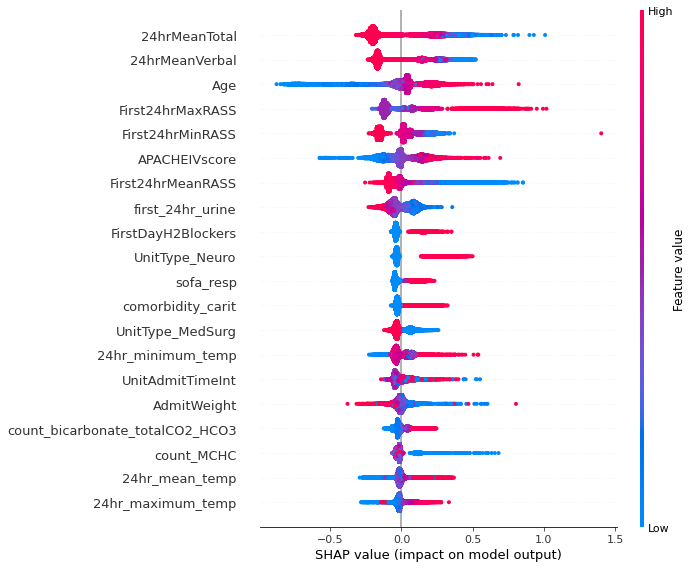

In [27]:
import shap
from catboost import CatBoostClassifier
clf = CatBoostClassifier(**{"n_estimators": 3000})
clf.fit(data.iloc[:,1:], labels)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(data.iloc[:, 1:])
shap.summary_plot(shap_values, data.iloc[:, 1:], show=False)
plt.savefig("../figures/{}_shapley_plot_full.png".format(name), bbox_inches="tight")

In [27]:
catboost_result = run_parallel_cross_validation(data_pruned, 
												"CatBoostClassifier",
												{"n_estimators": 3000},
												"from catboost import CatBoostClassifier",
												run_once = True,
												bayes=False,
												calibrate=True,
												n_jobs=2,
												run_id=5,
												outer_tuning=True,
												outer_labels=labels)


Inner Validation Complete


In [29]:
with open("../pickle/early_24hr_data/mean_pruned/catboost", "wb") as f:
    pickle.dump(catboost_result, f)

In [1]:
import pickle
with open("../pickle/early_24hr_data/mean_pruned/catboost", "rb") as f:
    catboost_result = pickle.load(f)

In [2]:
with open("catboost.pkl", "wb") as f:
    pickle.dump(catboost_result["oauc"], f)

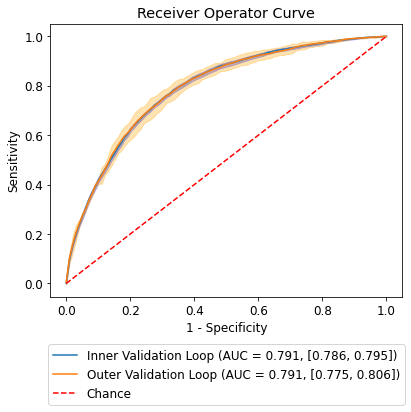

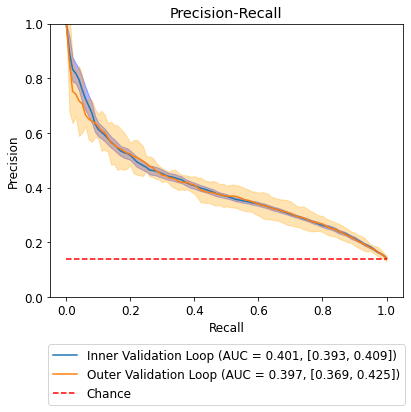

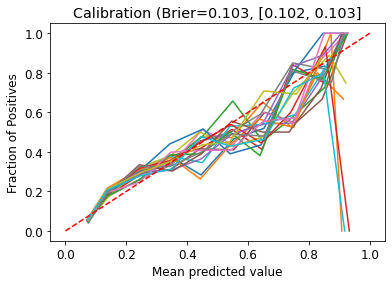

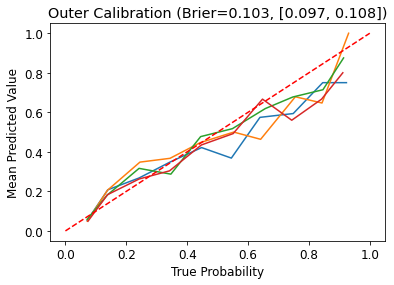

In [13]:
import pickle
with open("../pickle/early_24hr_data/mean_pruned/catboost", "rb") as f:
    catboost_result = pickle.load(f)


result_dict = catboost_result
name = "/early_24hr_data/mean_pruned/catboost"

base_fpr = np.linspace(0, 1, 100)

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

# ROC's
inner_mid_tpr, inner_up_tpr, inner_low_tpr = compute_confidence(result_dict["itpr"])
inner_mid_auc, inner_up_auc, inner_low_auc = compute_confidence(result_dict["iauc"])
outer_mid_tpr, outer_up_tpr, outer_low_tpr = compute_confidence(result_dict["otpr"])
outer_mid_auc, outer_up_auc, outer_low_auc = compute_confidence(result_dict["oauc"])
training_mid_tpr, training_up_tpr, training_low_tpr = compute_confidence(result_dict["ttpr"])
training_mid_auc, training_up_auc, training_low_auc = compute_confidence(result_dict["tauc"])

plt.figure(figsize=(6,6))
plt.plot(base_fpr, inner_mid_tpr, base_fpr, outer_mid_tpr, [0, 1], [0, 1], 'r--')
plt.fill_between(base_fpr, inner_low_tpr, inner_up_tpr, color='blue', alpha=0.3)
plt.fill_between(base_fpr, outer_low_tpr, outer_up_tpr, color='orange', alpha=0.3)
plt.xlabel("1 - Specificity") 
plt.ylabel("Sensitivity")
plt.title("Receiver Operator Curve")
plt.legend(("Inner Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(inner_mid_auc, inner_low_auc, inner_up_auc),
    "Outer Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_auc, outer_low_auc, outer_up_auc),
    'Chance'), loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_ROC.png".format(name), dpi = 'figure')
plt.show()

mid_precision, up_precision, low_precision = compute_confidence(result_dict["ip"])
mid_ap, up_ap, low_ap = compute_confidence(result_dict["iap"])
base_recall = np.linspace(1,0,101)

outer_mid_precision, outer_up_precision, outer_low_precision = compute_confidence(result_dict["op"])
outer_mid_ap, outer_up_ap, outer_low_ap = compute_confidence(result_dict["oap"])


plt.figure(figsize=(6,6))
plt.plot(base_recall, mid_precision, base_recall, outer_mid_precision, [0, 1], [pr_baseline, pr_baseline], 'r--')
plt.fill_between(base_recall, low_precision, up_precision, color='blue', alpha=0.3)
plt.fill_between(base_recall, outer_low_precision, outer_up_precision, color='orange', alpha=0.3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.ylim([0,1])
plt.legend(("Inner Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(mid_ap, low_ap, up_ap),
    "Outer Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_ap, outer_low_ap, outer_up_ap),
    'Chance'),
    loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_PR.png".format(name), dpi = 'figure')
plt.show()



mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["ibrier"]))

plt.figure()
for i in range(len(result_dict["iprobtrue"])):
    plt.plot(result_dict["iprobpred"][i], result_dict["iprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration.png".format(name), dpi = 'figure')
plt.show()

mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["obrier"]))

plt.figure()
for i in range(len(result_dict["oprobtrue"])):
    plt.plot(result_dict["oprobpred"][i], result_dict["oprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("True Probability")
plt.ylabel("Mean Predicted Value")
plt.title("Outer Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}])".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration_outer.png".format(name), dpi = 'figure')
plt.show()

Outer Loop 0
Threshold: 0.10645868629925244
Specificity: 0.7159493670886076
Sensitivity: 0.7165605095541401
PPV: 0.2862595419847328
NPV: 0.9407850964737192
Outer Loop 1
Threshold: 0.11736257370712147
Specificity: 0.7429811128126595
Sensitivity: 0.7424242424242424
PPV: 0.3273213092852371
NPV: 0.9448231093800714
Outer Loop 2
Threshold: 0.10929207502399371
Specificity: 0.712719857252103
Sensitivity: 0.7120980091883614
PPV: 0.29208542713567837
NPV: 0.9369973190348525
Outer Loop 3
Threshold: 0.11310101989618726
Specificity: 0.7197083961789844
Sensitivity: 0.719327731092437
PPV: 0.27738172391445237
NPV: 0.9448844884488449


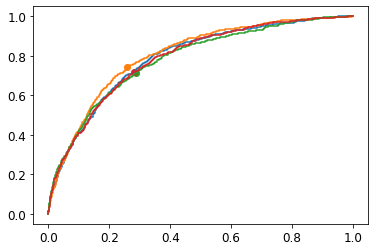

Average Specificity: (0.7228396833330887, 0.7446839083527972, 0.7009954583133802)
Average Sensitivity: (0.7226026230647953, 0.7441571989911486, 0.7010480471384419)
Average PPV: (0.2957620005800251, 0.33059535521806377, 0.26092864594198645)
Average NPV: (0.941872503334372, 0.9478776936404222, 0.9358673130283218)


In [23]:
from sklearn import metrics

total_spec = np.zeros(4)
total_sens = np.zeros(4)
total_ppv = np.zeros(4)
total_npv = np.zeros(4)


plt.figure()
for i in range(4):
    print("Outer Loop {}".format(i))
    fpr, tpr, thresholds = metrics.roc_curve(result_dict["olabels"][i], result_dict["ofullpred"][i])
    operating_point = np.argmin(abs(tpr-(1-fpr)))
    print("Threshold: {}".format(thresholds[operating_point]))
    plt.plot(fpr, tpr)
    plt.scatter(fpr[operating_point], tpr[operating_point])

    print("Specificity: {}".format(1-fpr[operating_point]))
    total_spec[i] = 1-fpr[operating_point]
    print("Sensitivity: {}".format(tpr[operating_point]))
    total_sens[i] = tpr[operating_point]



    tn, fp, fn, tp = metrics.confusion_matrix(result_dict["olabels"][i],  result_dict["ofullpred"][i] >= thresholds[operating_point]).ravel()
    print("PPV: {}".format(tp/(tp+fp)))
    print("NPV: {}".format(tn/(tn+fn)))

    total_ppv[i] = tp/(tp+fp)
    total_npv[i] = tn/(tn+fn)

#plt.xlim([0.2, 0.3])
plt.show()

print("Average Specificity: {}".format(compute_confidence(total_spec)))
print("Average Sensitivity: {}".format(compute_confidence(total_sens)))
print("Average PPV: {}".format(compute_confidence(total_ppv)))
print("Average NPV: {}".format(compute_confidence(total_npv)))

remaining: 8.85s
2624:	learn: 0.2222255	total: 1m 1s	remaining: 8.83s
2625:	learn: 0.2221906	total: 1m 1s	remaining: 8.81s
2626:	learn: 0.2221533	total: 1m 1s	remaining: 8.78s
2627:	learn: 0.2221255	total: 1m 1s	remaining: 8.76s
2628:	learn: 0.2220812	total: 1m 1s	remaining: 8.73s
2629:	learn: 0.2220647	total: 1m 1s	remaining: 8.71s
2630:	learn: 0.2220352	total: 1m 1s	remaining: 8.69s
2631:	learn: 0.2220341	total: 1m 1s	remaining: 8.66s
2632:	learn: 0.2219797	total: 1m 1s	remaining: 8.64s
2633:	learn: 0.2219444	total: 1m 2s	remaining: 8.62s
2634:	learn: 0.2218954	total: 1m 2s	remaining: 8.59s
2635:	learn: 0.2218573	total: 1m 2s	remaining: 8.57s
2636:	learn: 0.2218070	total: 1m 2s	remaining: 8.54s
2637:	learn: 0.2218027	total: 1m 2s	remaining: 8.52s
2638:	learn: 0.2217890	total: 1m 2s	remaining: 8.5s
2639:	learn: 0.2217335	total: 1m 2s	remaining: 8.48s
2640:	learn: 0.2216889	total: 1m 2s	remaining: 8.45s
2641:	learn: 0.2216521	total: 1m 2s	remaining: 8.43s
2642:	learn: 0.2216347	total: 

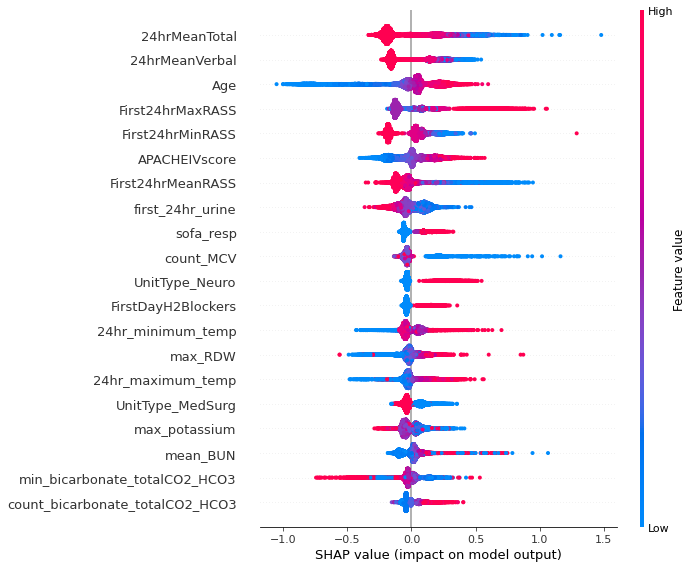

In [14]:
import shap
from catboost import CatBoostClassifier
clf = CatBoostClassifier(**{"n_estimators": 3000})
clf.fit(data_pruned.iloc[:,1:], labels)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(data_pruned.iloc[:, 1:])
shap.summary_plot(shap_values, data_pruned.iloc[:, 1:], show=False)
plt.savefig("../figures/{}_shapley_plot_full.png".format(name), bbox_inches="tight")

# Neural Net 
hasn't been rerun

In [50]:
class ClassifierModule(nn.Module):
    def __init__(self):
        super().__init__()

        self.hidden1 = nn.Linear(115, 200)
        self.hidden2 = nn.Linear(200, 75)
        self.output = nn.Linear(75, 2)

        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        self.drop = nn.Dropout(p=0.1)

    def forward(self, x):
        x = x.float()
        x = self.hidden1(x)
        x = self.drop(x)
        x = self.sigmoid(x)
        x = self.hidden2(x)
        x = self.drop(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        return x
from skorch.callbacks import EpochScoring
auc = EpochScoring(scoring='roc_auc', lower_is_better=False)
nll = nn.NLLLoss(weight=torch.tensor([0.25, 1]))

nn_result_3 = run_cross_validation(standard_data_pruned, "NeuralNetClassifier", {"module" : ClassifierModule, "max_epochs" : 100, "criterion" : nn.NLLLoss, "criterion__weight" : torch.tensor([0.25, 1]), "callbacks" : [auc]}, "from skorch import NeuralNetClassifier", run_once=True, bayes=False, numpy=True)

0.7217        0.5727       0.7299        0.6183  0.1765
     88     0.7219        0.5724       0.7263        0.6184  0.1815
     89     0.7221        0.5707       0.7284        0.6183  0.1656
     90     0.7223        0.5712       0.7263        0.6184  0.1865
     91     0.7223        0.5695       0.7299        0.6183  0.1785
     92     0.7225        0.5692       0.7294        0.6183  0.2084
     93     0.7226        0.5701       0.7284        0.6184  0.2024
     94     0.7227        0.5685       0.7279        0.6184  0.1865
     95     0.7227        0.5684       0.7269        0.6184  0.1825
     96     0.7228        0.5687       0.7269        0.6184  0.1936
     97     0.7229        0.5669       0.7279        0.6184  0.1735
     98     0.7229        0.5668       0.7274        0.6184  0.1835
     99     0.7229        0.5667       0.7269        0.6185  0.1845
    100     0.7229        0.5660       0.7269        0.6185  0.1890
  epoch    roc_auc    train_loss    valid_acc    valid_loss 

In [38]:
nn_result = run_cross_validation(standard_data_pruned, "MLPClassifier", {"hidden_layer_sizes" : (100, 50), "activation":"logistic", "alpha" : 1, "max_iter":500}, "from sklearn.neural_network import MLPClassifier", run_once=True, bayes=False)

In [59]:
nn_result_2 = run_cross_validation(standard_data_pruned, "MLPClassifier", {"hidden_layer_sizes" : (100, 100, 100, 100), "alpha" : 2, "max_iter":500}, "from sklearn.neural_network import MLPClassifier", run_once=True, bayes=False)

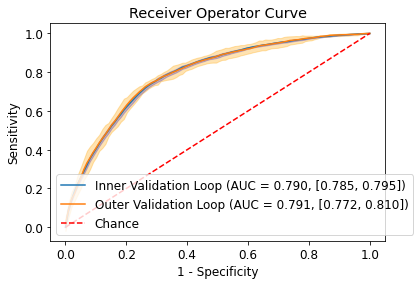

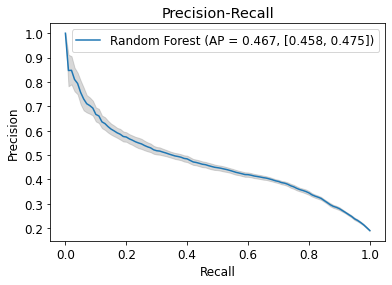

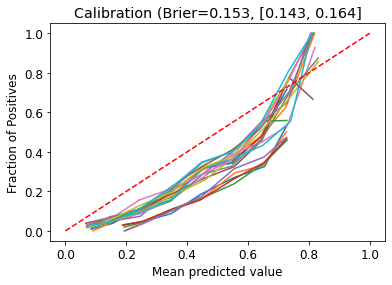

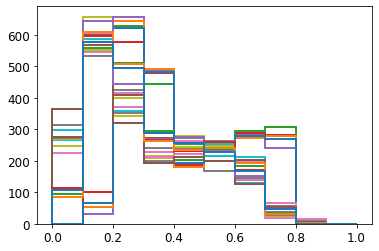

In [67]:
result_dict = rf_result
name = "rf_result"

base_fpr = np.linspace(0, 1, 100)

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

# ROC's
inner_mid_tpr, inner_up_tpr, inner_low_tpr = compute_confidence(result_dict["itpr"])
inner_mid_auc, inner_up_auc, inner_low_auc = compute_confidence(result_dict["iauc"])
outer_mid_tpr, outer_up_tpr, outer_low_tpr = compute_confidence(result_dict["otpr"])
outer_mid_auc, outer_up_auc, outer_low_auc = compute_confidence(result_dict["oauc"])
training_mid_tpr, training_up_tpr, training_low_tpr = compute_confidence(result_dict["ttpr"])
training_mid_auc, training_up_auc, training_low_auc = compute_confidence(result_dict["tauc"])

plt.figure()
plt.plot(base_fpr, inner_mid_tpr, base_fpr, outer_mid_tpr, [0, 1], [0, 1], 'r--')
plt.fill_between(base_fpr, inner_low_tpr, inner_up_tpr, color='blue', alpha=0.3)
plt.fill_between(base_fpr, outer_low_tpr, outer_up_tpr, color='orange', alpha=0.3)
plt.xlabel("1 - Specificity") 
plt.ylabel("Sensitivity")
plt.title("Receiver Operator Curve")
plt.legend(("Inner Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(inner_mid_auc, inner_low_auc, inner_up_auc),
    "Outer Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_auc, outer_low_auc, outer_up_auc),
    'Chance'))
plt.savefig("../figures/{}_ROC.png".format(name), dpi = 'figure')
plt.show()

mid_precision, up_precision, low_precision = compute_confidence(result_dict["ip"])
mid_ap, up_ap, low_ap = compute_confidence(result_dict["iap"])
base_recall = np.linspace(1,0,101)


plt.figure()
plt.plot(base_recall, mid_precision)
plt.fill_between(base_recall, low_precision, up_precision, color='grey', alpha=0.3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.legend(["Random Forest (AP = {0:.3f}, [{1:.3f}, {2:.3f}])".format(mid_ap, low_ap, up_ap)])
plt.savefig("../figures/{}_PR.png".format(name), dpi = 'figure')
plt.show()



mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["ibrier"]))
plt.figure()
for i in range(len(result_dict["iprobtrue"])):
    plt.plot(result_dict["iprobpred"][i], result_dict["iprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration.png".format(name), dpi = 'figure')
plt.show()

plt.figure()
plt.hist((np.asarray(result_dict["ifullpred"])).flatten(), range=(0, 1), bins=10, label=name,
            histtype="step", lw=2)
plt.show()

In [ ]:
rf_result["imodels"]

In [ ]:
explainer = shap.TreeExplainer(rf_result["imodels"][0])
clf.fit(data_pruned.iloc[:,1:], labels)



In [ ]:
rf_result["ipatid"][0]

In [ ]:
from sklearn.model_selection import StratifiedKFold
training_data, training_labels, testing_data, testing_labels, training_id, testing_id = split_table_to_sets(data, numpy = False, set_num = 0)
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 5)
ind = cv.split(training_data, training_labels)

X = training_data[ind]

In [ ]:
cv.split(training_data, training_labels)

In [ ]:
		for j, (cv_train, cv_test) in enumerate(cv.split(training_data, training_labels)):
